# AIR POLLUTION PREDICTION USING MACHINE LEARNING

# Connecting to Google Drive

In [1]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Setting current working directory to project folder

In [6]:
PWD = "gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast"
DATASET_PATH = f'PRSA_Data'
MODEL_PATH = f'models'
RESULTS_PATH = f'results'
CLEANED_DATASET_PATH = 'cleaned_datasets'

# setting working directory
%cd {PWD}

/content/gdrive/MyDrive/Projects/Hameedat Air Pollutant Forecast


In [ ]:
# MODEL_PATH = f'models'
# RESULTS_PATH = f'results'
# CLEANED_DATASET_PATH = 'cleaned_datasets'

In [ ]:
# Creating appropriate folders if not already existing

import os

# if not os.path.exists(DATASET_PATH):
#     os.mkdir(DATASET_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.mkdir(CLEANED_DATASET_PATH)


# Importing libararies

In [ ]:
!pip install skforecast

In [3]:
## Utilities
import os
import pickle
from math import sqrt
from numpy import log

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

## Forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg 
# from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom 
# from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect 

## Hyperparameter tunning
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import random_search_forecaster


## Saving and loading trained forecast models
from skforecast.utils import save_forecaster, load_forecaster

## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Allowing Auto-viewing of plots without having to call plt.show() everytime
%matplotlib inline

In [4]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['font.size']=12

# Loading datasets

In [7]:
#import five Beijng mulit-site air quality data for different cities
No = pd.read_csv(f'{CLEANED_DATASET_PATH}/Nongzhanguan_cleaned.csv', index_col=0, parse_dates=True)
No.index.freq = 'H'

## Exploratory Data Analysis (EDA)

In [ ]:
No.head()

,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5,PM10,SO2,NO2,CO,O3
datetime,,,,,,,,,,,,
2013-03-01 00:00:00,-0.5,1024.5,-21.4,0.0,337.5,5.7,5.0,14.0,4.0,12.0,200.0,85.0
2013-03-01 01:00:00,-0.7,1025.1,-22.1,0.0,315.0,3.9,8.0,12.0,6.0,14.0,200.0,84.0
2013-03-01 02:00:00,-1.2,1025.3,-24.6,0.0,337.5,5.3,3.0,6.0,5.0,14.0,200.0,83.0
2013-03-01 03:00:00,-1.4,1026.2,-25.5,0.0,360.0,4.9,5.0,5.0,5.0,14.0,200.0,84.0
2013-03-01 04:00:00,-1.9,1027.1,-24.5,0.0,337.5,3.2,5.0,5.0,6.0,21.0,200.0,77.0


In [ ]:
# View data shape sizes
print(f'Nongzhanguan Data shape: {No.shape}')

Nongzhanguan Data shape: (35064, 12)


In [ ]:
No.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    35064 non-null  float64
 1   PRES    35064 non-null  float64
 2   DEWP    35064 non-null  float64
 3   RAIN    35064 non-null  float64
 4   wd      35064 non-null  float64
 5   WSPM    35064 non-null  float64
 6   PM2.5   35064 non-null  float64
 7   PM10    35064 non-null  float64
 8   SO2     35064 non-null  float64
 9   NO2     35064 non-null  float64
 10  CO      35064 non-null  float64
 11  O3      35064 non-null  float64
dtypes: float64(12)
memory usage: 3.5+ MB


In [ ]:
#view data description
print(f'Nongzhanguan: \n {No.describe()}')

Nongzhanguan: 
                TEMP          PRES  ...            CO            O3
count  35064.000000  35064.000000  ...  35064.000000  35064.000000
mean      13.668250   1012.551871  ...   1327.767611     58.432876
std       11.459735     10.266471  ...   1257.098704     58.330590
min      -16.800000    987.100000  ...    100.000000      0.214200
25%        3.100000   1004.000000  ...    500.000000     10.000000
50%       14.600000   1012.200000  ...    900.000000     45.000000
75%       23.500000   1020.900000  ...   1600.000000     83.000000
max       41.100000   1042.000000  ...  10000.000000    390.000000

[8 rows x 12 columns]


In [ ]:
# Missing values
No.isna().sum()

TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
dtype: int64

# PREPROCESSING FOR MODELING

## My custom utility functions

In [12]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [13]:
def save_model_pickle(model, filename):
  try:
    pickle.dump(model, open(f'{MODEL_PATH}{filename}', 'wb'))
    print('Saved')
  except Exception as err:
    print(err)


def load_model_pickle(filename):
  try:
    model = pickle.load(open(f'{MODEL_PATH}{filename}', 'rb'))
    return model
  except Exception as err:
    print(err)
    return None

In [14]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    # mean_abs_prec_err = np.sum( np.abs(y_true - predictions) ) / sum_y_true
    # accuracy = 1 - mean_abs_prec_err
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)


In [15]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [16]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with PM2.5'):
    # Getting the Upper Triangle of the co-relation matrix
    upper_mat = np.triu(corr)
    upper_mat[np.diag_indices_from(upper_mat)] = False

    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap='Blues', mask=upper_mat,
                center=0, fmt='.2f', square=True)
    plt.title(title)


def visualize_series_single(series_data=None, days=None, title='PM2.5 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [17]:
features_X = No[No.columns[:6]]
y_pm25 = No['PM2.5']
y_pm10 = No.PM10
y_so2 = No.SO2
y_no2 = No.NO2
y_co = No.CO
y_o3 = No.O3

# FORECAST MODELS BUILDING

**Training Forecast Models on Nongzhanguan station series data**

# PM2.5

In [20]:
features_X.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2013-03-01 00:00:00,-0.5,1024.5,-21.4,0.0,337.5,5.7
2013-03-01 01:00:00,-0.7,1025.1,-22.1,0.0,315.0,3.9
2013-03-01 02:00:00,-1.2,1025.3,-24.6,0.0,337.5,5.3


In [ ]:
y_pm25.head(3)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
2013-03-01 02:00:00    3.0
Name: PM2.5, dtype: float64

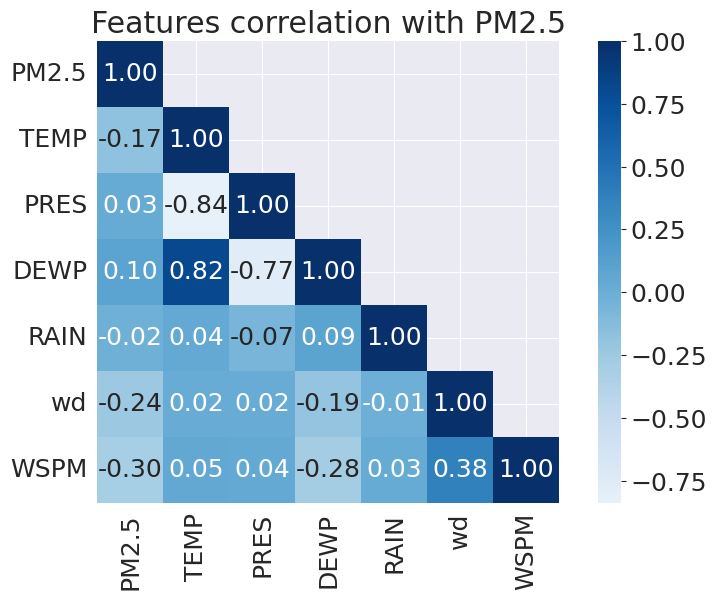

In [ ]:
# How features correlates with PM2.5
corr = pd.concat([y_pm25, features_X], axis='columns').corr()

plot_corr(corr, title='Features correlation with PM2.5')


**It can be observed that WSPM and wd have the strongest impact on PM2.5, the less WSPM or wd, the more PM2.5 air quality index and vice versa. PM2.5 is also affected by TEMP, the lesser the temprature, the more the PM2.5 air quality index.**

<Axes: title={'center': 'PM2.5 Series'}, xlabel='datetime'>

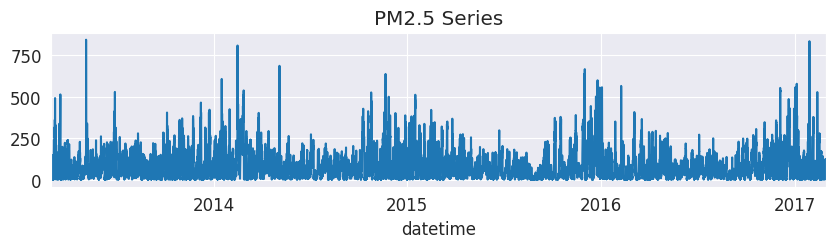

In [ ]:
plt.figure(figsize=(10,2))
y_pm25.plot(title='PM2.5 Series')

<Axes: title={'center': 'PM2.5 Series (last 6 months)'}, xlabel='datetime'>

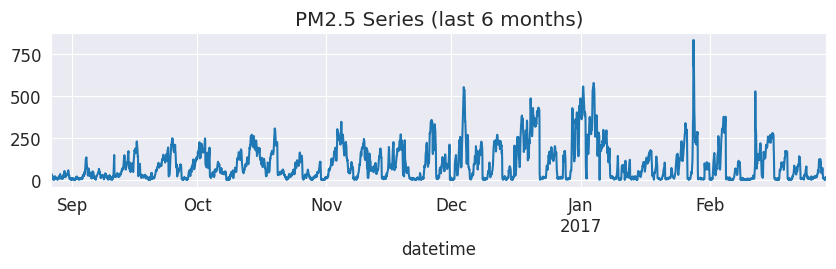

In [ ]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_pm25.iloc[-24*31*6:].plot(title='PM2.5 Series (last 6 months)')

### Decomposing series

**As shown in the plot above, Series data has varying (increasing and decreasing) seasonality over time. So, we decompose using multiplicative decomposition model, to understand its seasonal and trend components**

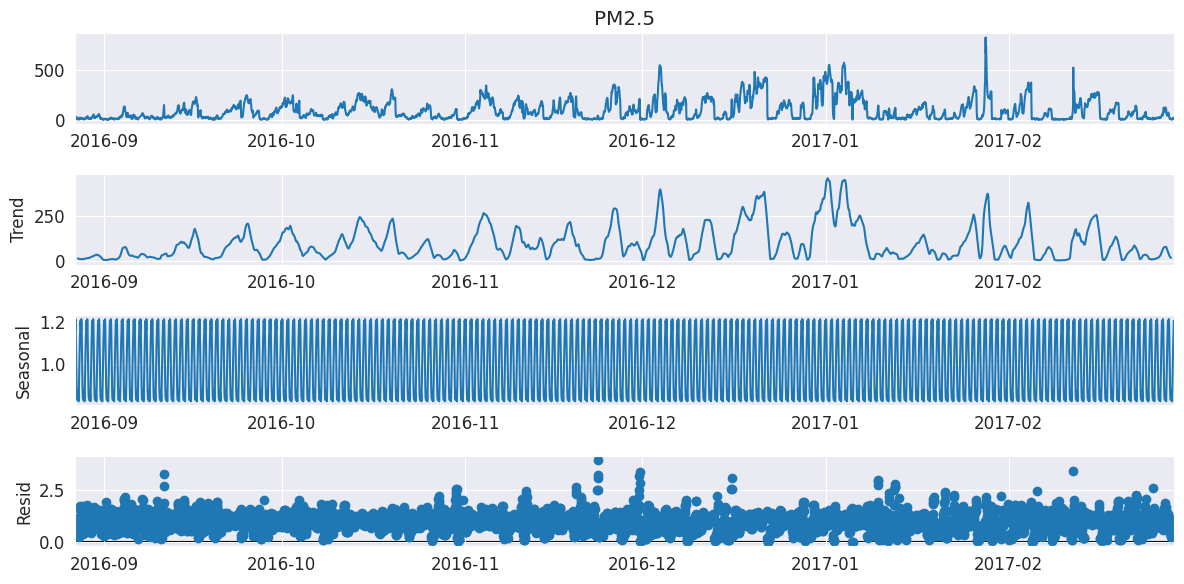

In [ ]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_pm25[-24*31*6:], model='multiplicative') # last 6 months

<Figure size 2400x900 with 0 Axes>

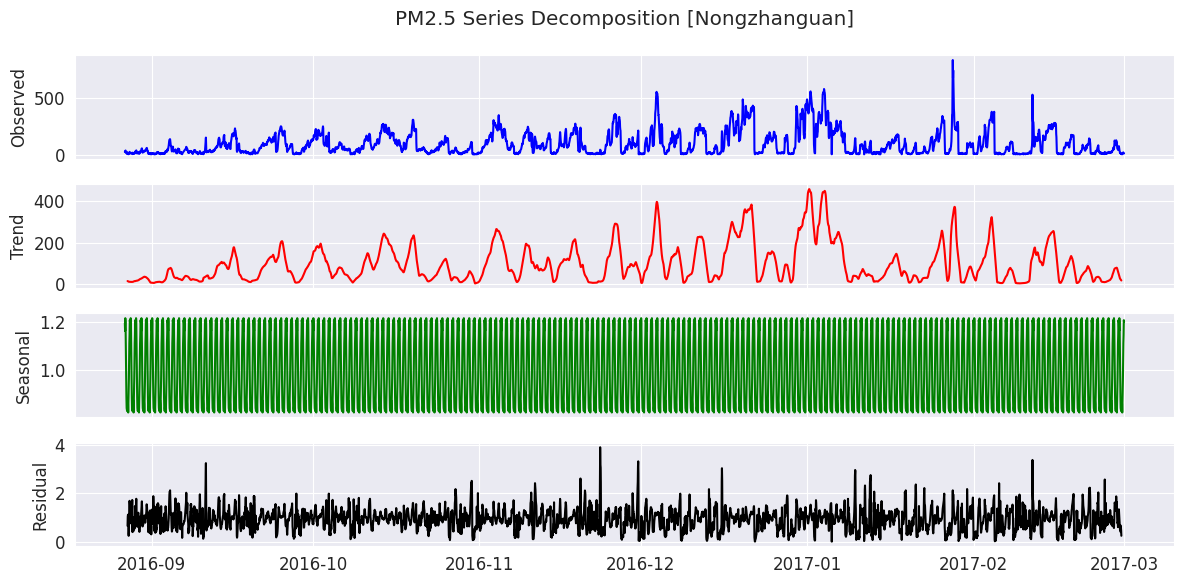

In [ ]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('PM2.5 Series Decomposition [Nongzhanguan]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()
 

### Checking for PM2.5 series stationarity
using adfuller test

In [ ]:
test_for_stationarity_single(y_pm25)

p-value: 0.0
Series is stationary


In [ ]:
# logged_pm25 = pm25_data.apply(np.log)

# plt.figure(figsize=(12,2))
# logged_pm25[-24*31*6:].plot()

# pm25_data == logged_pm25.apply(np.exp) # reverse-log-transform

**Having confirmed that series is stationary, after testing using adfuller test for stationarity, we can then proceed to use the series for forecast without transformation**

## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day Forecast (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [ ]:
steps = 24 # 24 hours Forecast --- Next Day Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [ ]:
# last one month for testing (24 * 31 hours )
train_pm25, test_pm25 = split_train_test_series_single(series_data=y_pm25, test_size=steps)

print(f'Train set Dates:\t {train_pm25.index.min()}  --- {train_pm25.index.max()}')
print(f'Test set Dates:\t\t {test_pm25.index.min()}  --- {test_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-27 23:00:00
Test set Dates:		 2017-02-28 00:00:00  --- 2017-02-28 23:00:00


Text(0.5, 1.0, 'PM2.5 [Nongzhanguan]\n')

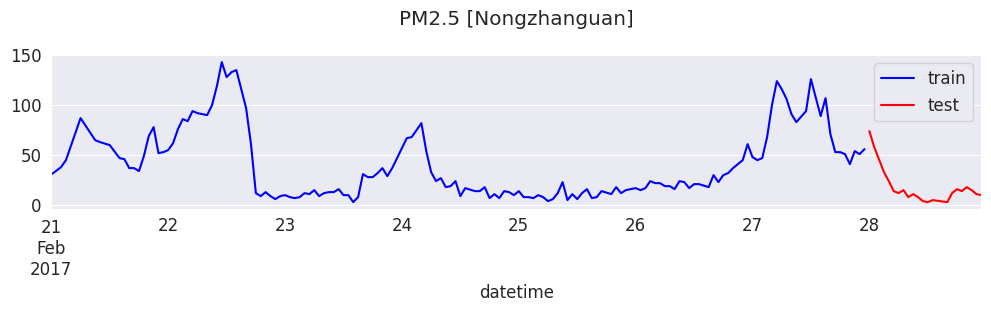

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 [Nongzhanguan]\n')

#### Decision Tree

In [ ]:
# Training
dt_forecaster_pm25 = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25.fit(y=train_pm25)
dt_forecaster_pm25

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-27 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-14 06:37:04 
Last fit date: 2023-05-14 06:37:05 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_dt_nt = dt_forecaster_pm25.predict(steps=steps)
preds_pm25_dt_nt.index = test_pm25.index
# dt_preds_pm25 = test_pm25.apply(np.exp).round(0)
preds_pm25_dt_nt.head()

datetime
2017-02-28 00:00:00    58.0
2017-02-28 01:00:00    59.0
2017-02-28 02:00:00    61.0
2017-02-28 03:00:00    83.0
2017-02-28 04:00:00    71.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 1-Day Forecast of Decision Tree using 24-lags [Nongzhanguan]\n')

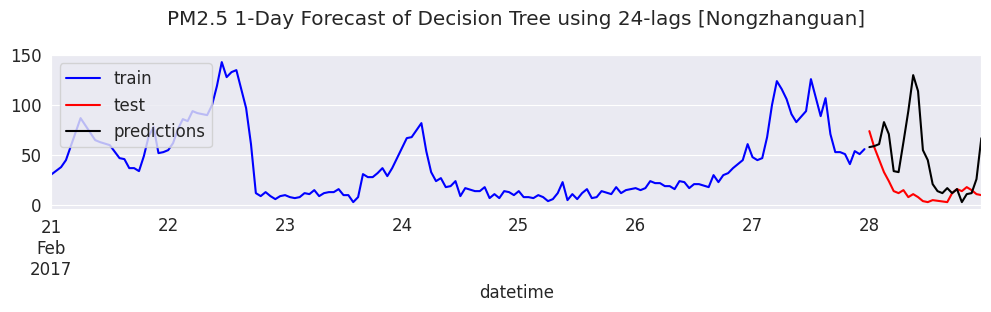

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
preds_pm25_dt_nt.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Day Forecast of Decision Tree using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune = evaluate_model_performance(
    y_true=test_pm25, 
    predictions=preds_pm25_dt_nt, 
    label='dt_pm25_no_tune')

results_pm25_dt_notune

,dt_pm25_no_tune
MAE,31.812
MSE,2074.047
RMSE,45.542
R-Squared,-5.687
MAPE,3.867


#### SVM (Regressor)

In [ ]:
# Training
svm_forecaster_pm25_nt = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt.fit(y=train_pm25)
svm_forecaster_pm25_nt

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-27 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-14 06:39:12 
Last fit date: 2023-05-14 06:39:19 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
svm_preds_pm25_nt = svm_forecaster_pm25_nt.predict(steps=steps)
svm_preds_pm25_nt.index = test_pm25.index
# svm_preds_pm25 = test_pm25.apply(np.exp).round(0)
svm_preds_pm25_nt.head()

datetime
2017-02-28 00:00:00    48.883631
2017-02-28 01:00:00    42.587218
2017-02-28 02:00:00    32.800454
2017-02-28 03:00:00    25.127371
2017-02-28 04:00:00    20.158668
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5  1-Day Forecast of SVM using 24-lags [Nongzhanguan]\n')

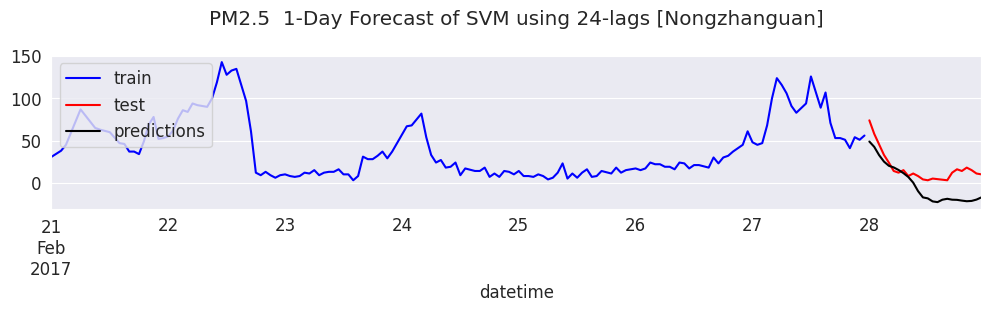

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
svm_preds_pm25_nt.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5  1-Day Forecast of SVM using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_svm_notune = evaluate_model_performance(
    y_true=test_pm25, predictions=svm_preds_pm25_nt, label='svm_pm25_no_tune')

results_pm25_svm_notune

,svm_pm25_no_tune
MAE,20.261
MSE,550.215
RMSE,23.457
R-Squared,-0.774
MAPE,2.543


#### Random Forest (Regressor)

In [ ]:
# Training
rf_forecaster_pm25_nt = ForecasterAutoreg(
                regressor = RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = 24
             )

rf_forecaster_pm25_nt.fit(y=train_pm25)
rf_forecaster_pm25_nt

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-27 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-14 06:40:56 
Last fit date: 2023-05-14 06:43:04 
Skforecast ve

In [ ]:
# Predictions
rf_preds_pm25_nt = rf_forecaster_pm25_nt.predict(steps=steps)
rf_preds_pm25_nt.index = test_pm25.index
# rf_preds_pm25 = test_pm25.apply(np.exp).round(0)
rf_preds_pm25_nt.head()

datetime
2017-02-28 00:00:00    59.966667
2017-02-28 01:00:00    64.120000
2017-02-28 02:00:00    67.913333
2017-02-28 03:00:00    71.466667
2017-02-28 04:00:00    73.444444
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 1-Day Forecast of Random Forest using 24-lags [Nongzhanguan]\n')

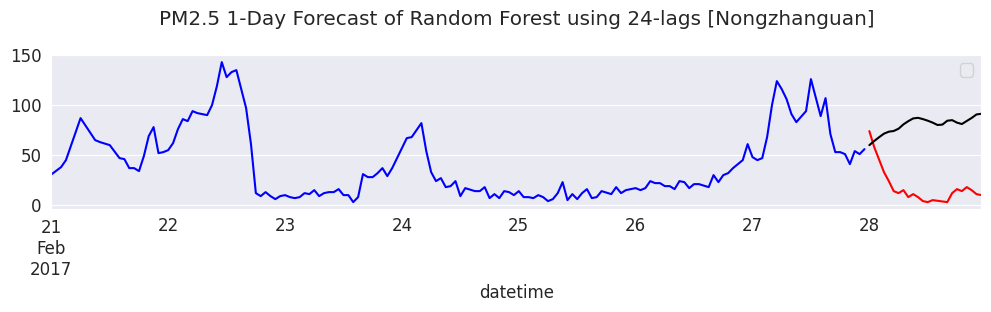

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*7:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
rf_preds_pm25_nt.plot(color='black', label='predictions')
plt.legend('')
plt.title('PM2.5 1-Day Forecast of Random Forest using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_rf_notune = evaluate_model_performance(
    y_true=test_pm25, predictions=rf_preds_pm25_nt, label='rf_pm25_no_tune')

results_pm25_rf_notune

,rf_pm25_no_tune
MAE,63.855
MSE,4540.115
RMSE,67.380
R-Squared,-13.638
MAPE,8.832


In [ ]:
results_one_day_forecast_nt = pd.concat([
    results_pm25_dt_notune, 
    results_pm25_rf_notune,
    results_pm25_svm_notune
    ], axis='columns')
results_one_day_forecast_nt

,dt_pm25_no_tune,rf_pm25_no_tune,svm_pm25_no_tune
MAE,31.812,63.855,20.261
MSE,2074.047,4540.115,550.215
RMSE,45.542,67.380,23.457
R-Squared,-5.687,-13.638,-0.774
MAPE,3.867,8.832,2.543


<Figure size 800x400 with 0 Axes>

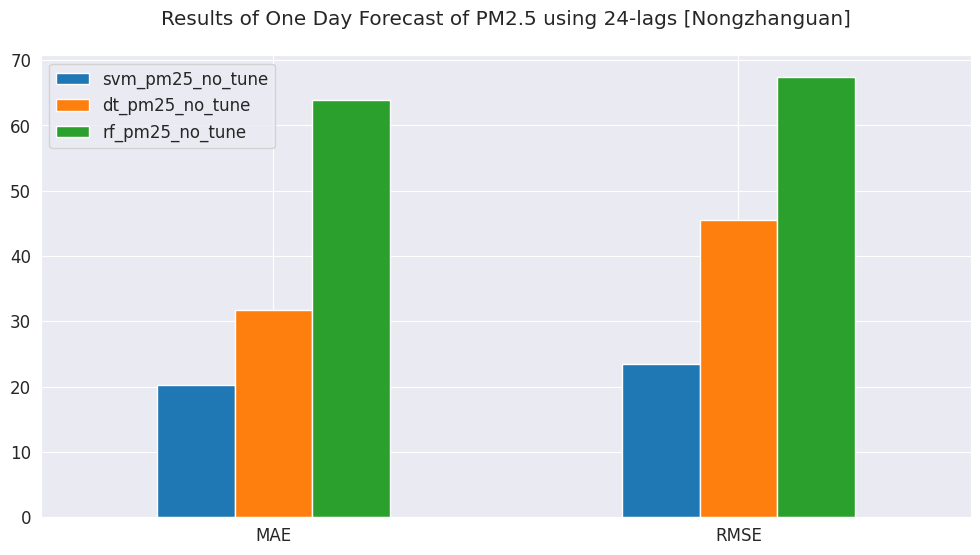

In [ ]:
plt.figure(figsize=(8,4))
results_one_day_forecast_nt.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day Forecast of PM2.5 using 24-lags [Nongzhanguan]\n', rot=0)
plt.legend(loc='upper left')

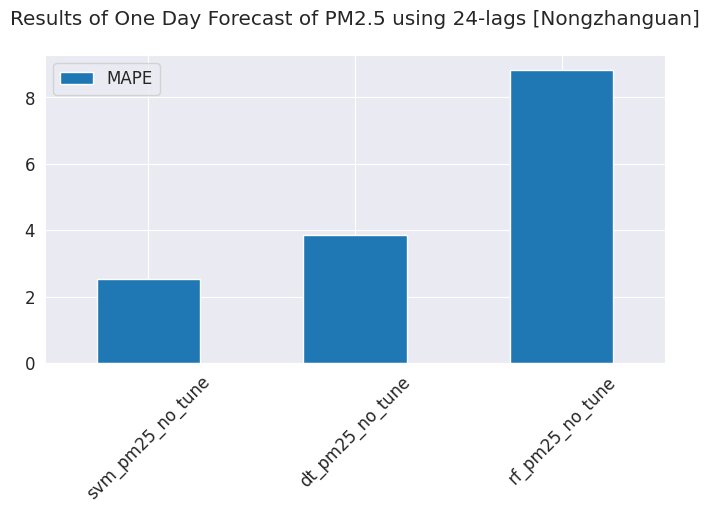

In [ ]:
plt.figure(figsize=(8,4))
results_one_day_forecast_nt.T['MAPE'].sort_values().T.plot.bar(
    title='Results of One Day Forecast of PM2.5 using 24-lags [Nongzhanguan]\n', rot=45)
plt.legend(loc='upper left')

In [ ]:
# Saving a copy of results
results_one_day_forecast_nt.to_csv(f'{RESULTS_PATH}/results_1_day_forecast_notune_24lags_Nongzhanguan.csv')

### Seven Days (168 hrs) Forecast without Exogeous Meterological Predictors

- Forecast next 168 hours (7 days) forecast (steps)
- Using 24 hours lag (Widow size), past data


In [ ]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [ ]:
# last one month for testing (24 * 31 hours )
train_pm25, test_pm25 = split_train_test_series_single(series_data=y_pm25, test_size=steps)

print(f'Train set Dates:\t {train_pm25.index.min()}  --- {train_pm25.index.max()}')
print(f'Test set Dates:\t\t {test_pm25.index.min()}  --- {test_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


Text(0.5, 1.0, 'PM2.5 [Nongzhanguan]\n')

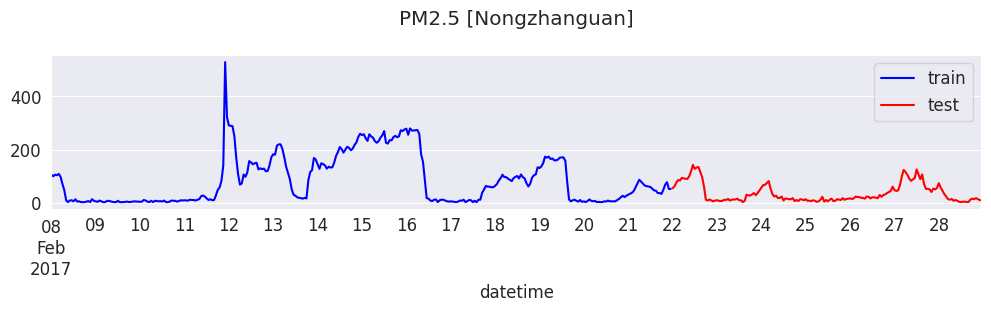

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 [Nongzhanguan]\n')

#### Decision Tree

In [ ]:
# Training
dt_forecaster_pm25_nomet = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25_nomet.fit(y=train_pm25)
dt_forecaster_pm25_nomet

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-14 06:56:24 
Last fit date: 2023-05-14 06:56:25 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_dt_nt_nomet = dt_forecaster_pm25_nomet.predict(steps=steps)
# preds_pm25_dt_nt_nomet.index = test_pm25.index
# dt_preds_pm25 = test_pm25.apply(np.exp).round(0)
preds_pm25_dt_nt_nomet.head()

2017-02-22 00:00:00    47.0
2017-02-22 01:00:00    44.0
2017-02-22 02:00:00    50.0
2017-02-22 03:00:00    69.0
2017-02-22 04:00:00    71.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 7-Day Forecast of Decision Tree using 24-lags [Nongzhanguan]\n')

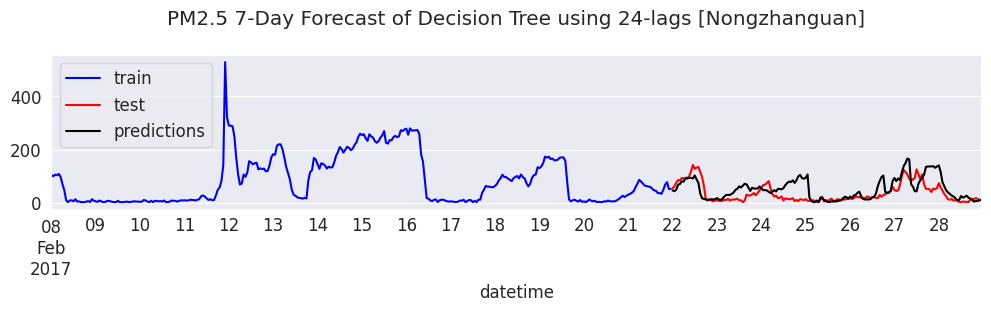

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
preds_pm25_dt_nt_nomet.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 7-Day Forecast of Decision Tree using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, 
    predictions=preds_pm25_dt_nt_nomet, 
    label='dt_pm25_no_tune_nomet')

results_pm25_dt_notune_nomet

,dt_pm25_no_tune_nomet
MAE,27.493
MSE,1466.957
RMSE,38.301
R-Squared,-0.193
MAPE,1.572


#### SVM (Regressor)

In [ ]:
# Training
svm_forecaster_pm25_nt_nomet = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt_nomet.fit(y=train_pm25)
svm_forecaster_pm25_nt_nomet

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-14 06:57:39 
Last fit date: 2023-05-14 06:57:49 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
svm_preds_pm25_nt_nomet = svm_forecaster_pm25_nt_nomet.predict(steps=steps)
svm_preds_pm25_nt_nomet.head()

2017-02-22 00:00:00    50.689352
2017-02-22 01:00:00    47.192873
2017-02-22 02:00:00    38.934487
2017-02-22 03:00:00    31.630529
2017-02-22 04:00:00    27.255267
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 7-Day Forecast of SVM using 24-lags [Nongzhanguan]\n')

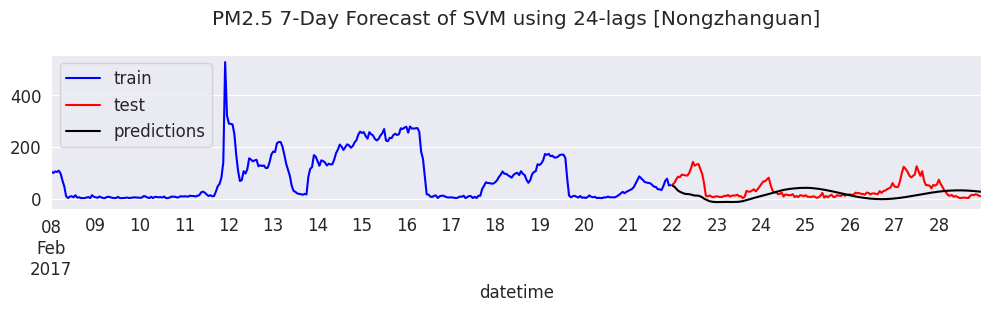

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
svm_preds_pm25_nt_nomet.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 7-Day Forecast of SVM using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_svm_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, predictions=svm_preds_pm25_nt_nomet, label='svm_pm25_no_tune_nomet')

results_pm25_svm_notune_nomet

,svm_pm25_no_tune_nomet
MAE,34.837
MSE,1996.824
RMSE,44.686
R-Squared,-0.624
MAPE,1.649


#### Random Forest (Regressor)

In [ ]:
# Training
rf_forecaster_pm25_nt_nomet = ForecasterAutoreg(
                regressor = RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = 24
             )

rf_forecaster_pm25_nt_nomet.fit(y=train_pm25)
rf_forecaster_pm25_nt_nomet

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-14 06:58:49 
Last fit date: 2023-05-14 07:01:18 
Skforecast ve

In [ ]:
# Predictions
rf_preds_pm25_nt_nomet = rf_forecaster_pm25_nt_nomet.predict(steps=steps)
rf_preds_pm25_nt_nomet.head()

2017-02-22 00:00:00    54.871111
2017-02-22 01:00:00    58.773333
2017-02-22 02:00:00    61.780000
2017-02-22 03:00:00    63.160000
2017-02-22 04:00:00    64.420000
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 7-Day Forecast of Random Forest using 24-lags [Nongzhanguan]\n')

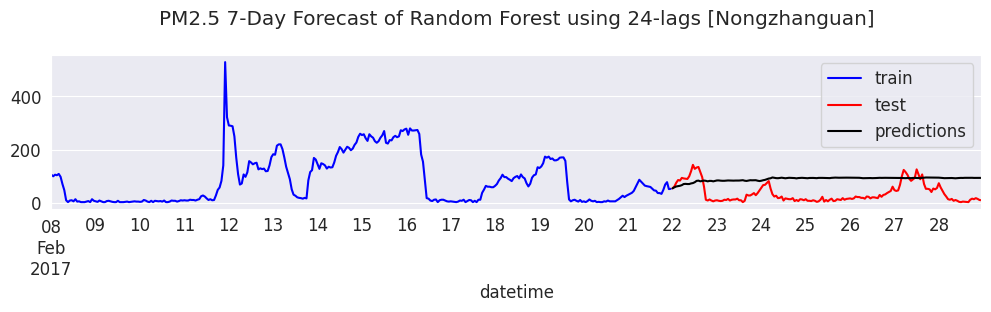

In [ ]:
plt.figure(figsize=(12,2))
train_pm25[-24*14:].plot(color='blue', label='train')
test_pm25.plot(color='red', label='test')
rf_preds_pm25_nt_nomet.plot(color='black', label='predictions')
plt.legend()
plt.title('PM2.5 7-Day Forecast of Random Forest using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_rf_notune_nomet = evaluate_model_performance(
    y_true=test_pm25, predictions=rf_preds_pm25_nt_nomet, label='rf_pm25_no_tune_nomet')

results_pm25_rf_notune_nomet

,rf_pm25_no_tune_nomet
MAE,60.551
MSE,4313.768
RMSE,65.679
R-Squared,-2.509
MAPE,5.118


In [ ]:
results_7_day_forecast_nt_nomet = pd.concat([
    results_pm25_dt_notune_nomet,
    results_pm25_rf_notune_nomet,
    results_pm25_svm_notune_nomet
    ], axis='columns')
results_7_day_forecast_nt_nomet

,dt_pm25_no_tune_nomet,rf_pm25_no_tune_nomet,svm_pm25_no_tune_nomet
MAE,27.493,60.551,34.837
MSE,1466.957,4313.768,1996.824
RMSE,38.301,65.679,44.686
R-Squared,-0.193,-2.509,-0.624
MAPE,1.572,5.118,1.649


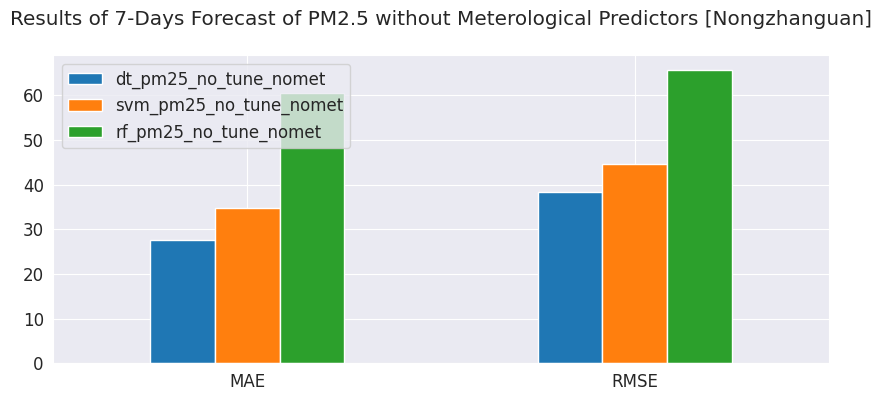

In [ ]:
results_7_day_forecast_nt_nomet.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of 7-Days Forecast of PM2.5 without Meterological Predictors [Nongzhanguan]\n',
    figsize=(10,4), rot=0)
plt.legend(loc='upper left')

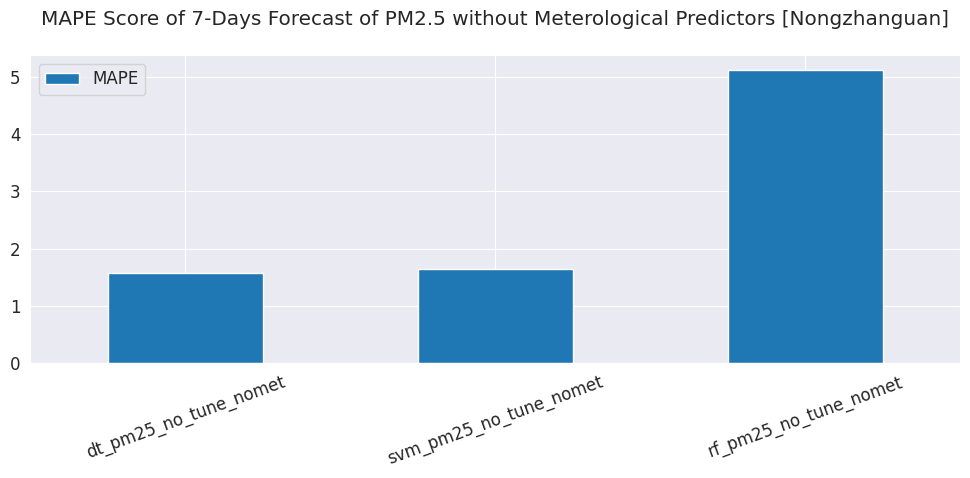

In [ ]:
plt.figure(figsize=(12,4))
results_7_day_forecast_nt_nomet.T['MAPE'].sort_values().T.plot.bar(
    title='MAPE Score of 7-Days Forecast of PM2.5 without Meterological Predictors [Nongzhanguan]\n', 
    rot=20)
plt.legend(loc='upper left')

In [ ]:
# Saving results
results_7_day_forecast_nt_nomet.to_csv(f'{RESULTS_PATH}/results_7_day_forecast_notune_nomet_24lags_Nongzhanguan.csv')
results_one_day_forecast_nt.to_csv(f'{RESULTS_PATH}/results_1_day_forecast_notune_nomet_24lags_Nongzhanguan.csv')

### One Month (next 744 hrs) Forecast Without exogenous data

Using 

- 48 hours lag
- Log transformation on PM2.5 (to make series more stationary)
- Custom built

In [ ]:
STEPS = 24 * 31 # forecast next one month PM2.5 = next 744 hrs
N_LAGS = 48 # window size of recent 48 hours data

#### Preparing data

In [ ]:
# Converting Series data into supervised learning data format

pm25_data = series_to_supervised_dataset_single(y_pm25.apply(np.log), n_lags=N_LAGS)
pm25_data.head()

,PM25t-48,PM25t-47,PM25t-46,PM25t-45,PM25t-44,PM25t-43,PM25t-42,PM25t-41,PM25t-40,PM25t-39,...,PM25t-9,PM25t-8,PM25t-7,PM25t-6,PM25t-5,PM25t-4,PM25t-3,PM25t-2,PM25t-1,PM2.5
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-03 00:00:00,1.609438,2.079442,1.098612,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,...,3.178054,3.737670,3.988984,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021
2013-03-03 01:00:00,2.079442,1.098612,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,1.098612,...,3.737670,3.988984,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021,4.897840
2013-03-03 02:00:00,1.098612,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,1.098612,1.098612,...,3.988984,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021,4.897840,4.976734
2013-03-03 03:00:00,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,1.098612,1.098612,1.098612,...,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021,4.897840,4.976734,4.934474
2013-03-03 04:00:00,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,1.098612,1.098612,1.098612,1.098612,...,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021,4.897840,4.976734,4.934474,4.465908


In [ ]:
# Train-Test split

Xtrain, ytrain, Xtest, ytest = split_train_test_series_multivariate_series(pm25_data, test_size=STEPS)

In [ ]:
Xtrain.head(3)

,PM25t-48,PM25t-47,PM25t-46,PM25t-45,PM25t-44,PM25t-43,PM25t-42,PM25t-41,PM25t-40,PM25t-39,...,PM25t-10,PM25t-9,PM25t-8,PM25t-7,PM25t-6,PM25t-5,PM25t-4,PM25t-3,PM25t-2,PM25t-1
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-03 00:00:00,1.609438,2.079442,1.098612,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,...,3.496508,3.178054,3.737670,3.988984,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789
2013-03-03 01:00:00,2.079442,1.098612,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,1.098612,...,3.178054,3.737670,3.988984,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021
2013-03-03 02:00:00,1.098612,1.609438,1.609438,1.098612,1.386294,1.098612,1.098612,2.397895,1.098612,1.098612,...,3.737670,3.988984,4.143135,4.158883,4.174387,4.234107,4.418841,4.521789,4.804021,4.897840


In [ ]:
ytrain.head(3)

datetime
2013-03-03 00:00:00    4.804021
2013-03-03 01:00:00    4.897840
2013-03-03 02:00:00    4.976734
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
Xtest.head(3)

,PM25t-48,PM25t-47,PM25t-46,PM25t-45,PM25t-44,PM25t-43,PM25t-42,PM25t-41,PM25t-40,PM25t-39,...,PM25t-10,PM25t-9,PM25t-8,PM25t-7,PM25t-6,PM25t-5,PM25t-4,PM25t-3,PM25t-2,PM25t-1
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-29 00:00:00,1.609438,2.079442,1.609438,2.197225,2.197225,1.945910,2.484907,2.564949,2.397895,2.772589,...,5.402677,5.476464,5.463832,5.472271,5.393628,5.356586,5.497168,5.525453,5.605802,5.659482
2017-01-29 01:00:00,2.079442,1.609438,2.197225,2.197225,1.945910,2.484907,2.564949,2.397895,2.772589,3.135494,...,5.476464,5.463832,5.472271,5.393628,5.356586,5.497168,5.525453,5.605802,5.659482,5.602119
2017-01-29 02:00:00,1.609438,2.197225,2.197225,1.945910,2.484907,2.564949,2.397895,2.772589,3.135494,3.433987,...,5.463832,5.472271,5.393628,5.356586,5.497168,5.525453,5.605802,5.659482,5.602119,5.659482


In [ ]:
ytest.head(3)

datetime
2017-01-29 00:00:00    5.602119
2017-01-29 01:00:00    5.659482
2017-01-29 02:00:00    5.484797
Freq: H, Name: PM2.5, dtype: float64

#### Decision Tree Regressor

In [ ]:
# Decision Tree Regressor
dt = DecisionTreeRegressor(criterion='squared_error', random_state=60)

dt.fit(Xtrain.values, ytrain.values)
preds = predict_series_multivariate(Xtest, model=dt, n_lags=N_LAGS)
preds.apply(np.exp).head()

(1, 48)


datetime
2017-01-29 00:00:00    352.0
2017-01-29 01:00:00    400.0
2017-01-29 02:00:00    403.0
2017-01-29 03:00:00    440.0
2017-01-29 04:00:00    452.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
results_dt_pm25_nt = evaluate_model_performance(
    ytest.apply(np.exp), preds.apply(np.exp), label='dt_pm25_nt')

results_dt_pm25_nt

,dt_pm25_nt
MAE,84.289
MSE,13930.509
RMSE,118.028
R-Squared,-0.819
MAPE,5.538


Text(0.5, 1.0, 'PM2.5 1-Month Forecast of Decision Tree using 48-lags [custom][Nongzhanguan]\n')

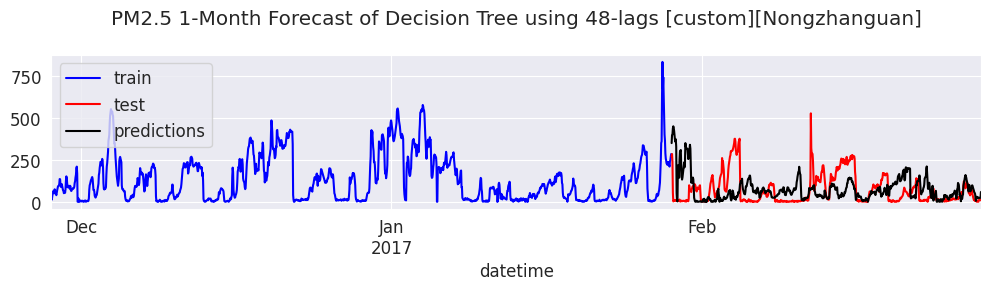

In [ ]:
plt.figure(figsize=(12,2))
ytrain[-24*31*2:].apply(np.exp).plot(color='blue', label='train')
ytest.apply(np.exp).plot(color='red', label='test')
preds.apply(np.exp).plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Month Forecast of Decision Tree using 48-lags [custom][Nongzhanguan]\n')

#### Random Forest

In [ ]:
# Random Forest
rf = RandomForestRegressor(random_state=60)
rf.fit(Xtrain.values, ytrain.values)

preds_rf = predict_series_multivariate(Xtest, model=rf, n_lags=N_LAGS)
preds_rf.apply(np.exp).head()

(1, 48)


datetime
2017-01-29 00:00:00    292.054717
2017-01-29 01:00:00    261.584915
2017-01-29 02:00:00    234.691173
2017-01-29 03:00:00    198.410088
2017-01-29 04:00:00    152.467513
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
results_rf_pm25_nt = evaluate_model_performance(
    ytest.apply(np.exp), preds_rf.apply(np.exp), label='rf_pm25_nt')

results_rf_pm25_nt

,rf_pm25_nt
MAE,62.898
MSE,7992.088
RMSE,89.398
R-Squared,-0.044
MAPE,3.251


Text(0.5, 1.0, 'PM2.5 1-Month Forecast of Random Forest using 48-lags [custom][Nongzhanguan]\n')

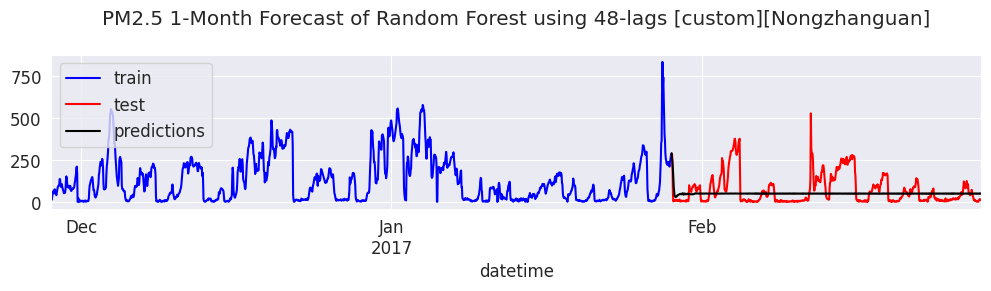

In [ ]:
plt.figure(figsize=(12,2))
ytrain[-24*31*2:].apply(np.exp).plot(color='blue', label='train')
ytest.apply(np.exp).plot(color='red', label='test')
preds_rf.apply(np.exp).plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Month Forecast of Random Forest using 48-lags [custom][Nongzhanguan]\n')

#### Support Vector Machine (SVM)

In [ ]:
# SVR
svr = LinearSVR(random_state=60)
svr.fit(Xtrain.values, ytrain.values)

preds_svr = predict_series_multivariate(Xtest, model=svr, n_lags=N_LAGS)
preds_svr.apply(np.exp).head()

(1, 48)


datetime
2017-01-29 00:00:00    230.037336
2017-01-29 01:00:00    186.317813
2017-01-29 02:00:00    151.036184
2017-01-29 03:00:00    118.845879
2017-01-29 04:00:00     94.217588
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
results_svr_pm25_nt = evaluate_model_performance(
    ytest.apply(np.exp), preds_svr.apply(np.exp), label='svr_pm25_nt')

results_svr_pm25_nt

,svr_pm25_nt
MAE,63.861
MSE,10939.022
RMSE,104.590
R-Squared,-0.429
MAPE,1.001


Text(0.5, 1.0, 'PM2.5 1-Month Forecast of SVM using 48-lags [custom][Nongzhanguan]\n')

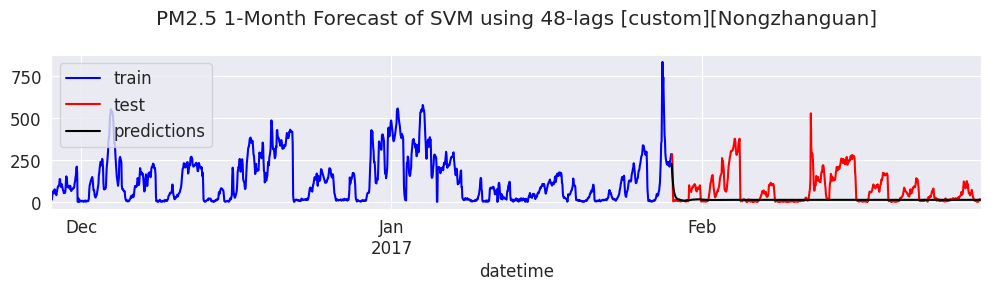

In [ ]:
plt.figure(figsize=(12,2))
ytrain[-24*31*2:].apply(np.exp).plot(color='blue', label='train')
ytest.apply(np.exp).plot(color='red', label='test')
preds_svr.apply(np.exp).plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 1-Month Forecast of SVM using 48-lags [custom][Nongzhanguan]\n')

In [ ]:
results_pm25_1_month_forecast_notune_nomet_48lags = pd.concat([
    results_dt_pm25_nt, results_svr_pm25_nt, results_rf_pm25_nt],
    axis='columns')

results_pm25_1_month_forecast_notune_nomet_48lags 

,dt_pm25_nt,svr_pm25_nt,rf_pm25_nt
MAE,84.289,63.861,62.898
MSE,13930.509,10939.022,7992.088
RMSE,118.028,104.590,89.398
R-Squared,-0.819,-0.429,-0.044
MAPE,5.538,1.001,3.251


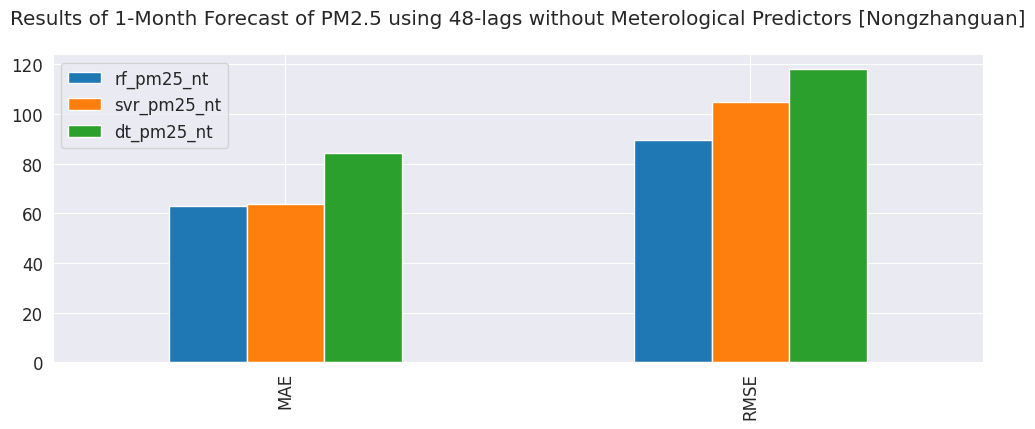

In [ ]:
results_pm25_1_month_forecast_notune_nomet_48lags.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of 1-Month Forecast of PM2.5 using 48-lags without Meterological Predictors [Nongzhanguan]\n',
    figsize=(12,4))
plt.legend(loc='upper left')

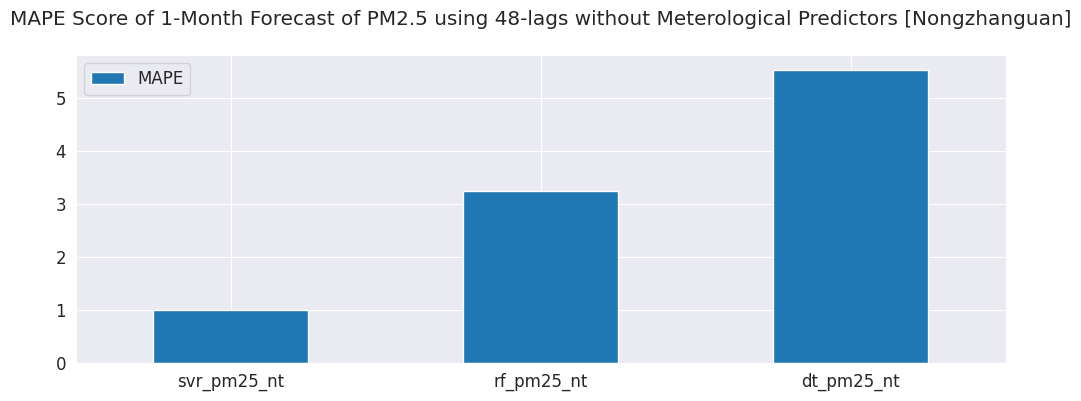

In [ ]:
results_pm25_1_month_forecast_notune_nomet_48lags.T['MAPE'].sort_values().T.plot.bar(
    title='MAPE Score of 1-Month Forecast of PM2.5 using 48-lags without Meterological Predictors [Nongzhanguan]\n',
    figsize=(12,4), rot=0)
plt.legend(loc='upper left')

In [ ]:
# Saving a copy of the results
results_pm25_1_month_forecast_notune_nomet_48lags.to_csv(f'{RESULTS_PATH}/results_pm25_1_month_forecast_notune_nomet_48lags.csv')


## MODDELING FORECAST WITH EXOGENOUS METEROLOGICAL VARIABLES

### Seven Days  (168 hours, 1 week) Forecast (trained with Exogenous Meterological Predictor Variables included) + Feature Selection 

- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Feature Selection based on pearson correlation with Target (PM2.5) variable

In [ ]:
steps = 24 * 7 # 168 hours Forecast --- One Week Forecast
lags = 24  # using past 24 hours window size

#### Preparing data and Feature Selection

In [ ]:
features_X.corrwith(y_pm25).sort_values()

WSPM   -0.301098
wd     -0.240711
TEMP   -0.173362
RAIN   -0.022705
PRES    0.028121
DEWP    0.097226
dtype: float64

<Axes: title={'center': 'Feature Correlation with PM2.5 [Nongzhanguan]\n'}>

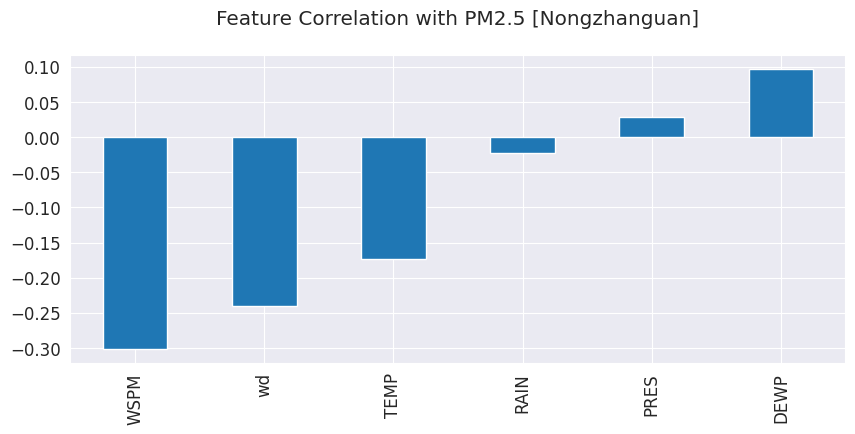

In [ ]:
## Feature Selection by correlation
features_X.corrwith(y_pm25).sort_values().plot.bar(title='Feature Correlation with PM2.5 [Nongzhanguan]\n', figsize=(10,4))

**Selected Features are {'WSPM', 'wd', 'TEMP'}**

In [ ]:
pm25_exog_data = pd.concat([features_X[['WSPM', 'wd', 'TEMP']], y_pm25], axis='columns')
pm25_exog_data.head()

,WSPM,wd,TEMP,PM2.5
datetime,,,,
2013-03-01 00:00:00,5.7,337.5,-0.5,5.0
2013-03-01 01:00:00,3.9,315.0,-0.7,8.0
2013-03-01 02:00:00,5.3,337.5,-1.2,3.0
2013-03-01 03:00:00,4.9,360.0,-1.4,5.0
2013-03-01 04:00:00,3.2,337.5,-1.9,5.0


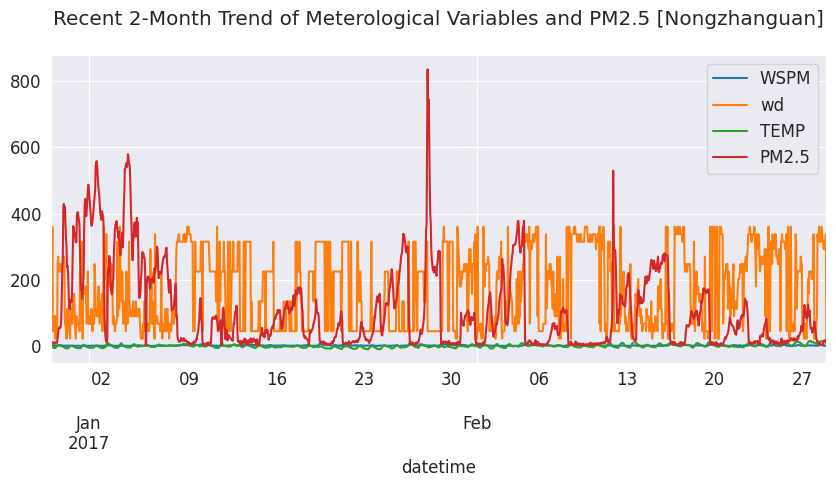

In [ ]:
plt.figure(figsize=(10,4))
for col in pm25_exog_data.columns:
    pm25_exog_data.iloc[-24*31*2:][col].plot(label=col)

plt.title('Recent 2-Month Trend of Meterological Variables and PM2.5 [Nongzhanguan]\n')
plt.legend()

#### Data Segmentation

In [ ]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=steps)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [ ]:
Xtrain_exo_pm25.head(3)

,WSPM,wd,TEMP
datetime,,,
2013-03-01 00:00:00,5.7,337.5,-0.5
2013-03-01 01:00:00,3.9,315.0,-0.7
2013-03-01 02:00:00,5.3,337.5,-1.2


In [ ]:
ytrain_exo_pm25.head(3)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
2013-03-01 02:00:00    3.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
Xtest_exo_pm25.head(3)

,WSPM,wd,TEMP
datetime,,,
2017-02-22 00:00:00,2.7,202.5,-2.3
2017-02-22 01:00:00,2.2,225.0,-2.3
2017-02-22 02:00:00,2.6,247.5,-2.3


In [ ]:
ytest_exo_pm25.head(3)

datetime
2017-02-22 00:00:00    55.0
2017-02-22 01:00:00    62.0
2017-02-22 02:00:00    76.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 3)
Xtest shape: (168, 3)


Text(0.5, 1.0, 'PM2.5 Recent 3-weeks [Nongzhanguan]\n')

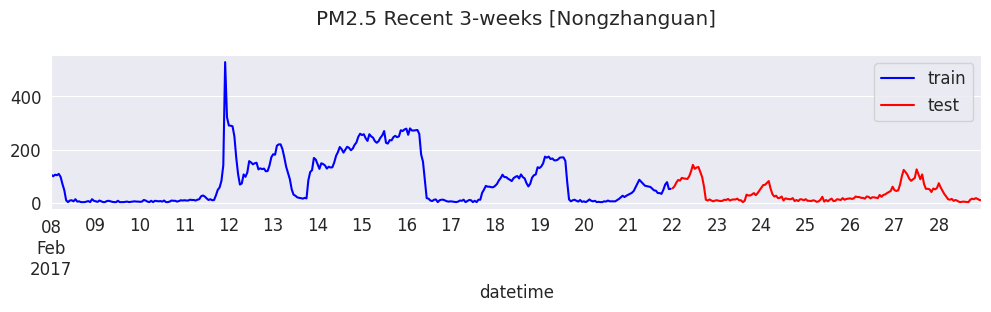

In [ ]:
plt.figure(figsize=(12,2))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 Recent 3-weeks [Nongzhanguan]\n')

#### Decision Tree

In [ ]:
# Training
dt_forecaster_pm25_exo_sel = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25_exo_sel.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
dt_forecaster_pm25_exo_sel

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-14 07:23:36 
Last fit date: 2023-05-14 07:23:37 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_dt_nt_exo_sel = dt_forecaster_pm25_exo_sel.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_dt_nt_exo_sel.head()

2017-02-22 00:00:00    51.666667
2017-02-22 01:00:00    51.666667
2017-02-22 02:00:00    51.666667
2017-02-22 03:00:00    51.666667
2017-02-22 04:00:00    51.666667
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Day Forecast of Decision Tree using 24-lags [Nongzhanguan]\n')

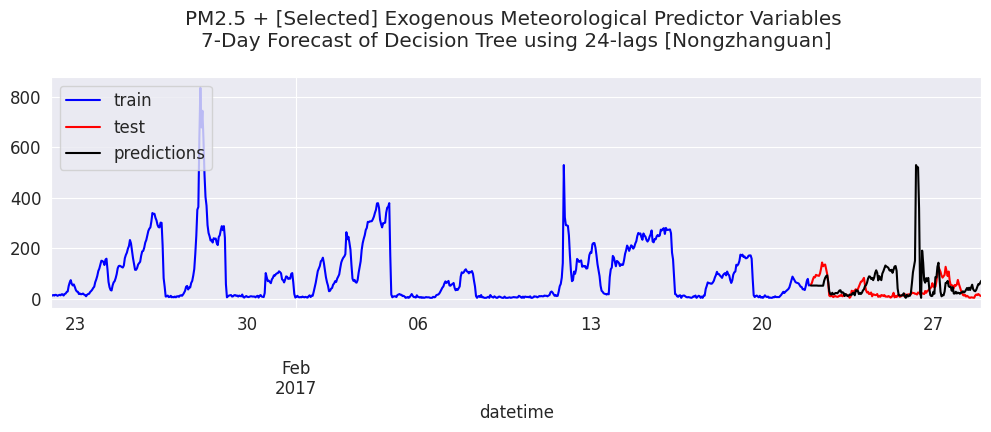

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_dt_nt_exo_sel.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Day Forecast of Decision Tree using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune_exo_sel = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_dt_nt_exo_sel, 
    label='dt_pm25_no_tune_exo_sel')

results_pm25_dt_notune_exo_sel

,dt_pm25_no_tune_exo_sel
MAE,50.601
MSE,7999.825
RMSE,89.442
R-Squared,-5.507
MAPE,3.408


#### SVM (Regressor)

In [ ]:
# Training
svm_forecaster_pm25_nt_exo_sel = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt_exo_sel.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
svm_forecaster_pm25_nt_exo_sel

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-15 20:59:44 
Last fit date: 2023-05-15 20:59:59 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_svm_nt_exo_sel = svm_forecaster_pm25_nt_exo_sel.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_svm_nt_exo_sel.head()

2017-02-22 00:00:00    57.902588
2017-02-22 01:00:00    64.431132
2017-02-22 02:00:00    71.503484
2017-02-22 03:00:00    77.454832
2017-02-22 04:00:00    84.460311
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of SVM using 24-lags [Nongzhanguan]\n')

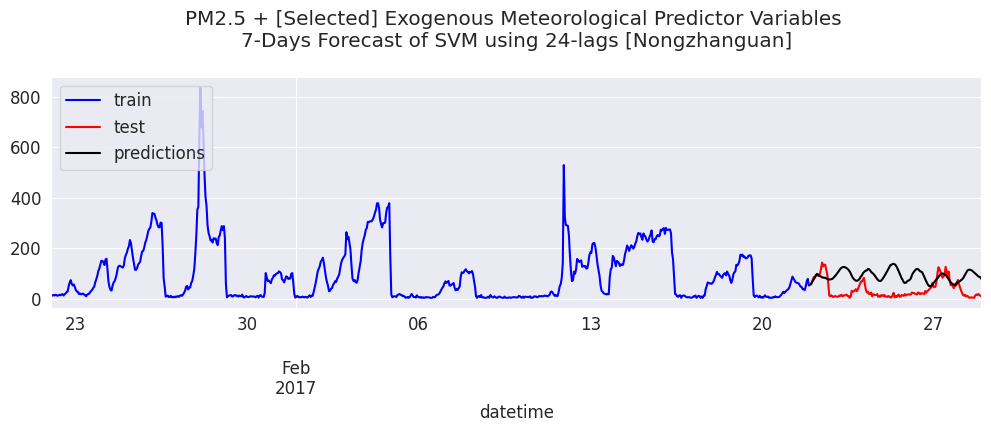

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_svm_nt_exo_sel.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of SVM using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_svm_notune_exo_sel = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_svm_nt_exo_sel, 
    label='svm_pm25_no_tune_exo_sel')

results_pm25_svm_notune_exo_sel

,svm_pm25_no_tune_exo_sel
MAE,60.239
MSE,5014.400
RMSE,70.812
R-Squared,-3.078
MAPE,5.641


#### Radom Forest (Regressor)


In [ ]:
# Training
rf_forecaster_pm25_nt_exo_sel = ForecasterAutoreg(
                regressor =RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = lags
             )

rf_forecaster_pm25_nt_exo_sel.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
rf_forecaster_pm25_nt_exo_sel

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-15 21:00:37 

In [ ]:
# Predictions
preds_pm25_rf_nt_exo_sel = rf_forecaster_pm25_nt_exo_sel.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_rf_nt_exo_sel.head()

2017-02-22 00:00:00    53.824444
2017-02-22 01:00:00    57.280000
2017-02-22 02:00:00    60.073333
2017-02-22 03:00:00    68.306667
2017-02-22 04:00:00    73.100000
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, 'PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of Random Forest using 24-lags [Nongzhanguan]\n')

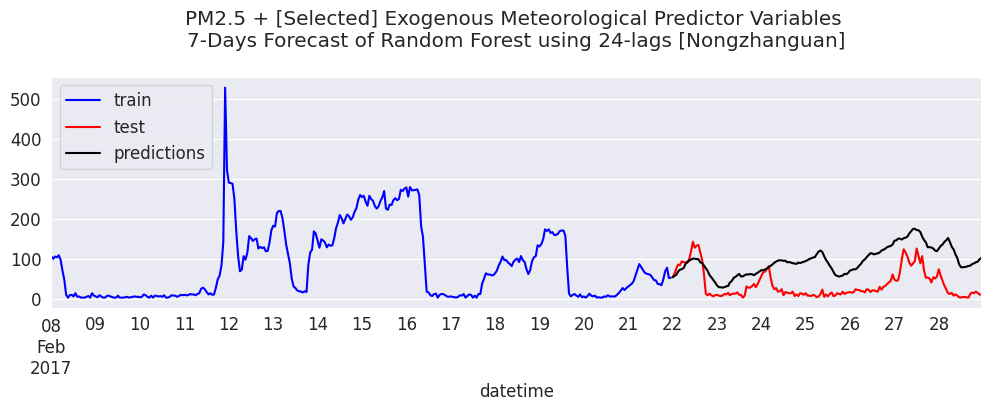

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_rf_nt_exo_sel.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('PM2.5 + [Selected] Exogenous Meteorological Predictor Variables \n7-Days Forecast of Random Forest using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_rf_notune_exo_sel = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_rf_nt_exo_sel, 
    label='rf_pm25_no_tune_exo_sel')

results_pm25_rf_notune_exo_sel

,rf_pm25_no_tune_exo_sel
MAE,61.785
MSE,4764.160
RMSE,69.023
R-Squared,-2.875
MAPE,4.618


#### Combined Results

In [ ]:
results_7_day_forecast_nt_exo_sel = pd.concat([
    results_pm25_dt_notune_exo_sel, 
    results_pm25_rf_notune_exo_sel,
    results_pm25_svm_notune_exo_sel
    ], axis='columns')

results_7_day_forecast_nt_exo_sel

,dt_pm25_no_tune_exo_sel,rf_pm25_no_tune_exo_sel,svm_pm25_no_tune_exo_sel
MAE,50.601,61.785,60.239
MSE,7999.825,4764.160,5014.400
RMSE,89.442,69.023,70.812
R-Squared,-5.507,-2.875,-3.078
MAPE,3.408,4.618,5.641


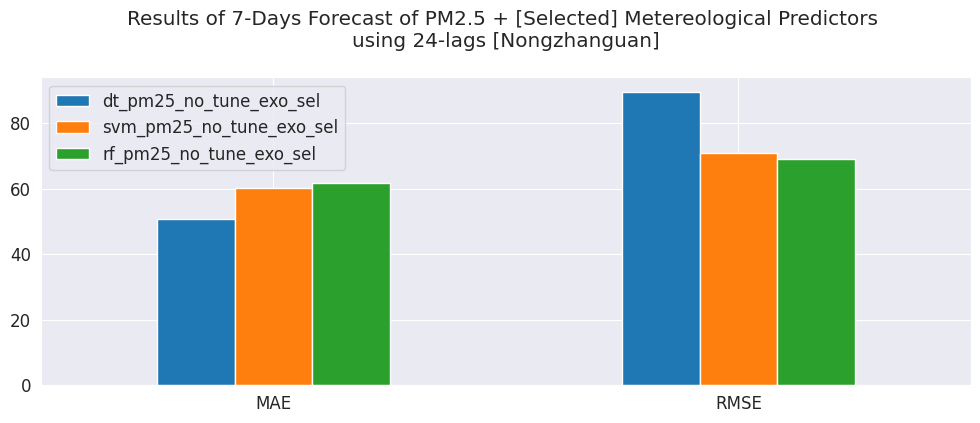

In [ ]:
results_7_day_forecast_nt_exo_sel.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of 7-Days Forecast of PM2.5 + [Selected] Metereological Predictors \nusing 24-lags [Nongzhanguan]\n',
    rot=0, figsize=(12,4))
plt.legend(loc='upper left')

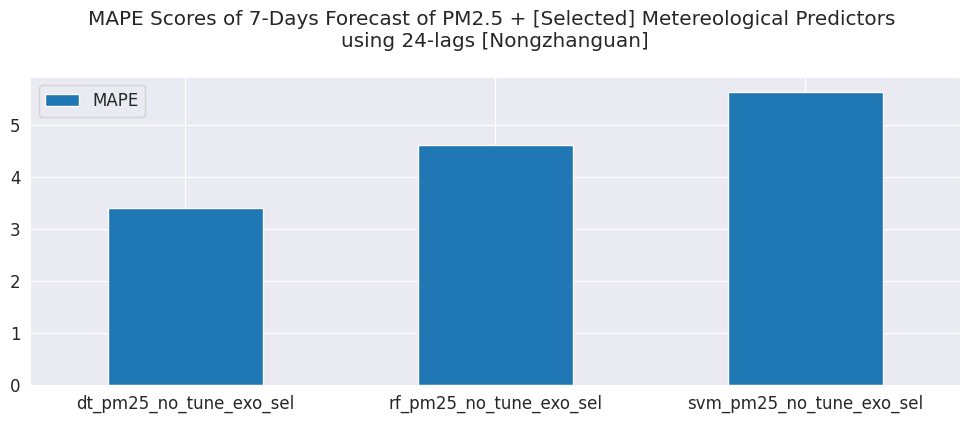

In [ ]:
results_7_day_forecast_nt_exo_sel.T['MAPE'].sort_values().T.plot.bar(
    title='MAPE Scores of 7-Days Forecast of PM2.5 + [Selected] Metereological Predictors \nusing 24-lags [Nongzhanguan]\n',
    rot=0, figsize=(12,4))
plt.legend(loc='upper left')

In [ ]:
# Saving a copy of results
results_7_day_forecast_nt_exo_sel.to_csv(f'{RESULTS_PATH}/results_7_day_forecast_notune_exo_sel_24lags_with_FeatureSelection.csv')

### Seven Days (1 week = 168 hours) Forecast (trained with Exogenous Meterological Predictor Variables included) + All-Features

- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- No Feature Selection (all features are used for comparative analysis)

In [ ]:
steps = 24 * 7 # 168 hours Forecast --- One Week Forecast
lags = 24  # using past 24 hours window size

#### Data Preparation

In [ ]:
pm25_exog_data = pd.concat([features_X, y_pm25], axis='columns')
pm25_exog_data.head()

,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5
datetime,,,,,,,
2013-03-01 00:00:00,-0.5,1024.5,-21.4,0.0,337.5,5.7,5.0
2013-03-01 01:00:00,-0.7,1025.1,-22.1,0.0,315.0,3.9,8.0
2013-03-01 02:00:00,-1.2,1025.3,-24.6,0.0,337.5,5.3,3.0
2013-03-01 03:00:00,-1.4,1026.2,-25.5,0.0,360.0,4.9,5.0
2013-03-01 04:00:00,-1.9,1027.1,-24.5,0.0,337.5,3.2,5.0


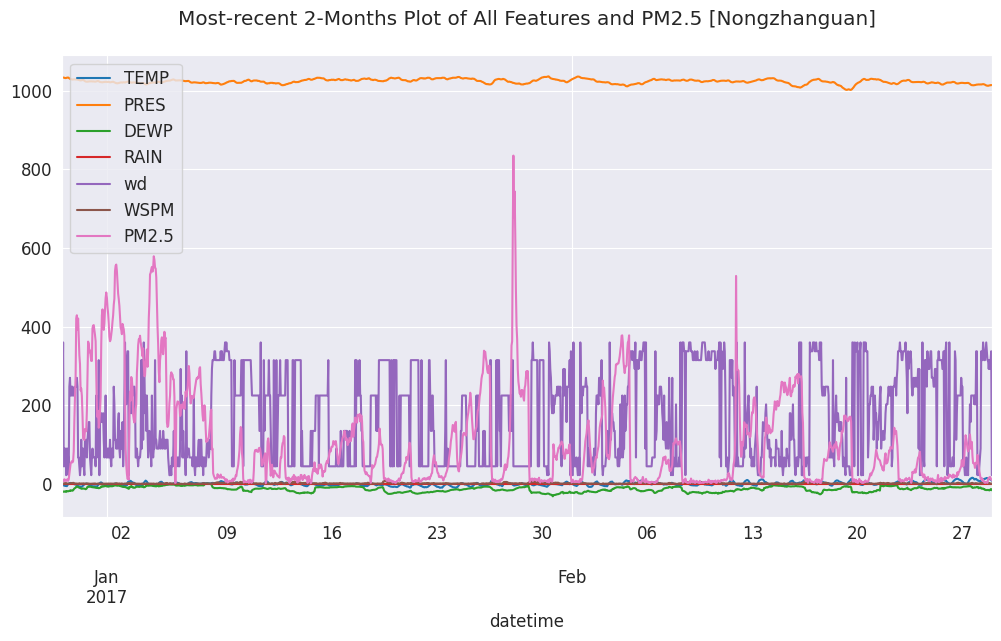

In [ ]:
for col in pm25_exog_data.columns:
    pm25_exog_data.iloc[-24*31*2:][col].plot(label=col)
plt.title('Most-recent 2-Months Plot of All Features and PM2.5 [Nongzhanguan]\n')
plt.legend(loc='upper left')

#### Data Segmentation (Train-test split)

In [ ]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=steps)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [ ]:
Xtrain_exo_pm25.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2013-03-01 00:00:00,-0.5,1024.5,-21.4,0.0,337.5,5.7
2013-03-01 01:00:00,-0.7,1025.1,-22.1,0.0,315.0,3.9
2013-03-01 02:00:00,-1.2,1025.3,-24.6,0.0,337.5,5.3


In [ ]:
ytrain_exo_pm25.head(3)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
2013-03-01 02:00:00    3.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
Xtest_exo_pm25.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2017-02-22 00:00:00,-2.3,1020.9,-5.0,0.0,202.5,2.7
2017-02-22 01:00:00,-2.3,1020.3,-5.4,0.0,225.0,2.2
2017-02-22 02:00:00,-2.3,1019.8,-5.3,0.0,247.5,2.6


In [ ]:
ytest_exo_pm25.head(3)

datetime
2017-02-22 00:00:00    55.0
2017-02-22 01:00:00    62.0
2017-02-22 02:00:00    76.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 6)
Xtest shape: (168, 6)


Text(0.5, 1.0, 'PM2.5 [Nongzhanguan]')

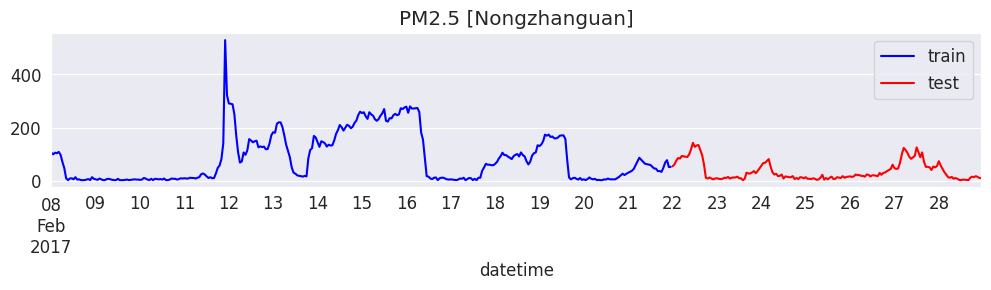

In [ ]:
plt.figure(figsize=(12,2))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 [Nongzhanguan]')

#### Decision Tree

In [ ]:
# Training
dt_forecaster_pm25_exo = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=2,
        random_state=60
        ),
    lags = lags)

dt_forecaster_pm25_exo.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
dt_forecaster_pm25_exo

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-15 21:10:51 
Last fit date: 2023-05-15 21:10:52 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: N

In [ ]:
# Predictions
preds_pm25_dt_nt_exo = dt_forecaster_pm25_exo.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_dt_nt_exo.head()

2017-02-22 00:00:00    40.0
2017-02-22 01:00:00    39.0
2017-02-22 02:00:00    28.0
2017-02-22 03:00:00    30.0
2017-02-22 04:00:00    30.0
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days Decision Tree Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Nongzhanguan]\n')

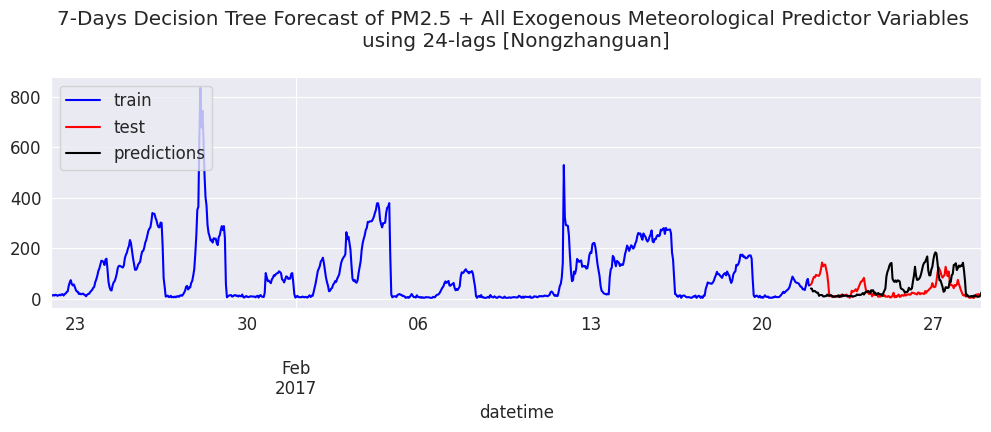

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_dt_nt_exo.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('7-Days Decision Tree Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune_exo = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_dt_nt_exo, 
    label='dt_pm25_no_tune_exo')

results_pm25_dt_notune_exo

,dt_pm25_no_tune_exo
MAE,44.169
MSE,3582.049
RMSE,59.850
R-Squared,-1.913
MAPE,2.167


#### SVM (Regressor)

In [ ]:
# Training
svm_forecaster_pm25_nt_exo = ForecasterAutoreg(
                regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
                lags = lags
             )

svm_forecaster_pm25_nt_exo.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
svm_forecaster_pm25_nt_exo

ForecasterAutoreg 
Regressor: LinearSVR(random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'random_state': 60, 'tol': 0.0001, 'verbose': 0} 
Creation date: 2023-05-15 21:11:39 
Last fit date: 2023-05-15 21:11:53 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_svm_nt_exo = svm_forecaster_pm25_nt_exo.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_svm_nt_exo.head()

2017-02-22 00:00:00    47.094916
2017-02-22 01:00:00    38.718018
2017-02-22 02:00:00    30.107188
2017-02-22 03:00:00    23.798373
2017-02-22 04:00:00    19.853291
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days SVM Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Nongzhanguan]\n')

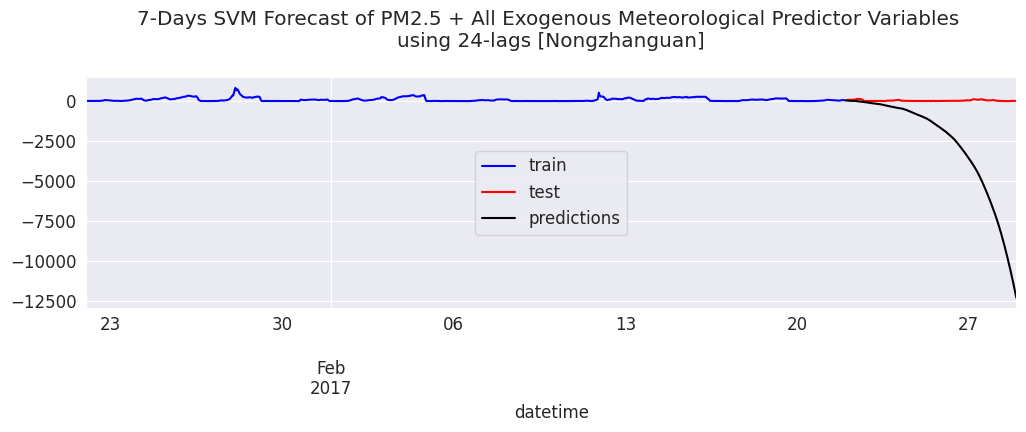

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_svm_nt_exo.plot(color='black', label='predictions')
plt.legend(loc='center')
plt.title('7-Days SVM Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_svm_notune_exo = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_svm_nt_exo, 
    label='svm_pm25_no_tune_exo')

results_pm25_svm_notune_exo

,svm_pm25_no_tune_exo
MAE,2.722476e+03
MSE,1.759617e+07
RMSE,4.194778e+03
R-Squared,-1.431051e+04
MAPE,2.164230e+02


#### Radom Forest (Regressor)


In [ ]:
# Training
rf_forecaster_pm25_nt_exo = ForecasterAutoreg(
                regressor =RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
                lags = lags
             )

rf_forecaster_pm25_nt_exo.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
rf_forecaster_pm25_nt_exo

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=150, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 60, 'verbose': 0, 'warm_start': False} 
Creation da

In [ ]:
# Predictions
preds_pm25_rf_nt_exo = rf_forecaster_pm25_nt_exo.predict(steps=steps, exog=Xtest_exo_pm25)
preds_pm25_rf_nt_exo.head()

2017-02-22 00:00:00    53.766667
2017-02-22 01:00:00    56.460000
2017-02-22 02:00:00    59.786667
2017-02-22 03:00:00    67.746667
2017-02-22 04:00:00    70.973333
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days Random Forest Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Nongzhanguan]\n')

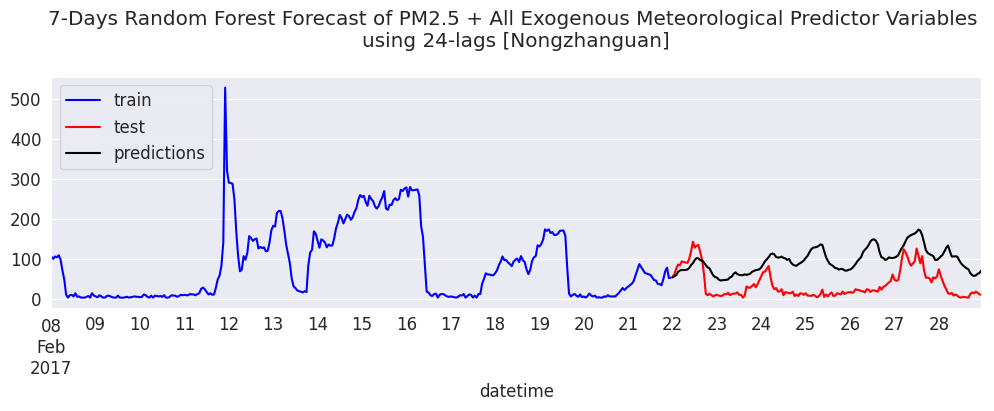

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*14:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_rf_nt_exo.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('7-Days Random Forest Forecast of PM2.5 + All Exogenous Meteorological Predictor Variables \nusing 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_rf_notune_exo = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_rf_nt_exo, 
    label='rf_pm25_no_tune_exo')

results_pm25_rf_notune_exo

,rf_pm25_no_tune_exo
MAE,63.391
MSE,4898.576
RMSE,69.990
R-Squared,-2.984
MAPE,4.939


#### Combined Results

In [ ]:
results_7_day_forecast_nt_exo = pd.concat([
    results_pm25_dt_notune_exo, 
    results_pm25_rf_notune_exo,
    results_pm25_svm_notune_exo
    ], axis='columns')
results_7_day_forecast_nt_exo

,dt_pm25_no_tune_exo,rf_pm25_no_tune_exo,svm_pm25_no_tune_exo
MAE,44.169,63.391,2.722476e+03
MSE,3582.049,4898.576,1.759617e+07
RMSE,59.850,69.990,4.194778e+03
R-Squared,-1.913,-2.984,-1.431051e+04
MAPE,2.167,4.939,2.164230e+02


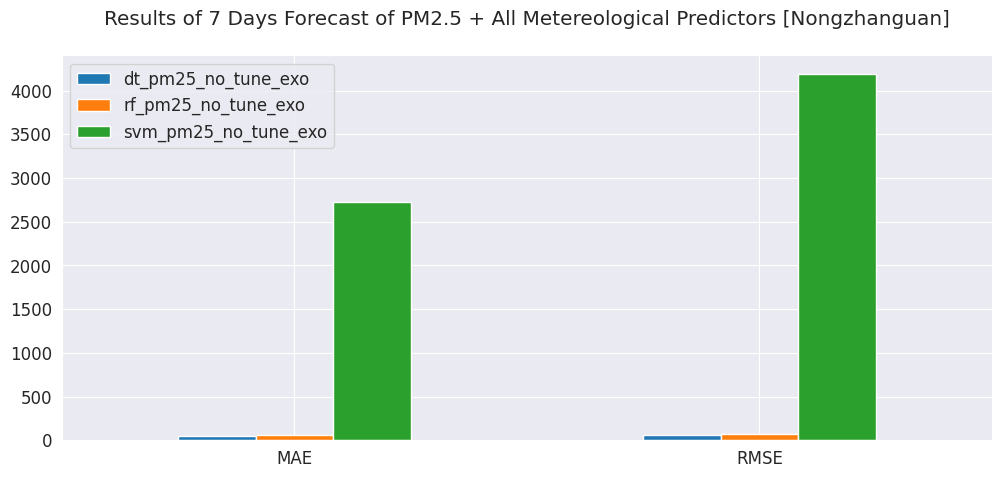

In [ ]:
results_7_day_forecast_nt_exo.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of 7 Days Forecast of PM2.5 + All Metereological Predictors [Nongzhanguan]\n',
    rot=0, figsize=(12,5))
plt.legend(loc='upper left')

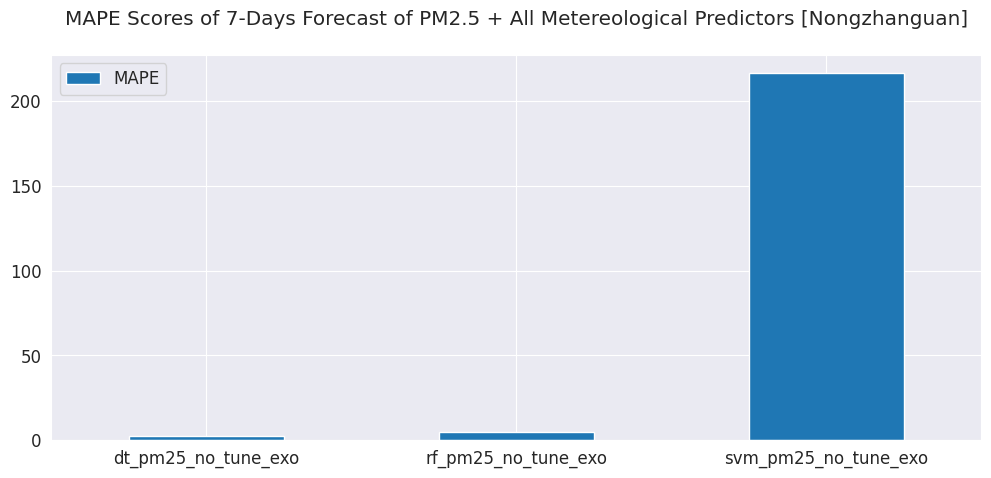

In [ ]:
results_7_day_forecast_nt_exo.T['MAPE'].sort_values().T.plot.bar(
    title='MAPE Scores of 7-Days Forecast of PM2.5 + All Metereological Predictors [Nongzhanguan]\n',
    rot=0, figsize=(12,5))
plt.legend(loc='upper left')

In [ ]:
# Saving a copy of results
results_7_day_forecast_nt_exo.to_csv(f'{RESULTS_PATH}/results_7_day_forecast_notune_all_exo_24lag.csv')

# MODEL OPTIMIZATION

1. Backtesting for time-series cross validation (walk-forward validation)
2. Forecast with Parameter Tunning using Grid Search

  **NOTE:**

  _We adopted a Backtesting with refit strategy, so that the model is refit (re-trained) each time to update the model to capture new series data, ensuring all data available for training are used._

---
- **Backtesting** refers to testing a predictive model on historical data by moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

  **Backtesting with refit and increasing training size (fixed origin)**

  - The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

---

## 1. Backtesting Validation (Walk-forward Cross Validation)

### Seven Days (1 week = 168 hours) Forecast (trained with Exogenous Meterological Predictor Variables included) + Feature Selection
- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Feature Selection (Selection based on Pearson correlation with PM2.5)
- Backtesting with refit (cross validation)

In [ ]:
STEPS = 24 * 7
LAGS = 24

# setting 5 days data for backtesting
# to take the 'steps' forward 5 times from historical data
N_BACKTESTING = STEPS * 5 

#### Preparing data and Feature Selection

**Selected Features are {'WSPM', 'wd', 'TEMP'}**

In [ ]:
pm25_exog_data = pd.concat([features_X[['WSPM', 'wd', 'TEMP']], y_pm25], axis='columns')
pm25_exog_data.head(3)

,WSPM,wd,TEMP,PM2.5
datetime,,,,
2013-03-01 00:00:00,5.7,337.5,-0.5,5.0
2013-03-01 01:00:00,3.9,315.0,-0.7,8.0
2013-03-01 02:00:00,5.3,337.5,-1.2,3.0


#### Data Segmentation

In [ ]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=STEPS)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [ ]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 3)
Xtest shape: (168, 3)


#### Decision Tree on PM2.5 (with Backtesting)

In [ ]:
fruits = ['wale', 'seun', 'dayo']
fruits.insert(2, 'apple')
fruits

['wale', 'seun', 'apple', 'dayo']

In [ ]:
eval_metrics = ['mean_absolute_error', 'mean_squared_error', 
                'mean_absolute_percentage_error']

dt_backtest_forecaster = ForecasterAutoreg(
        regressor = DecisionTreeRegressor(random_state=60),
        lags      = LAGS
      )

metrics, backtest_predictions = backtesting_forecaster(
        forecaster         = dt_backtest_forecaster,
        y                  = ytrain_exo_pm25,
        initial_train_size = len(ytrain_exo_pm25) - N_BACKTESTING,
        exog               = Xtrain_exo_pm25,
        interval           = [1, 99],
        fixed_train_size   = False,
        steps              = STEPS,
        metric             = eval_metrics,
        refit              = True,
        verbose            = True
    )

metrics.insert(2, np.sqrt(metrics[1]))
print(f'{"-" * 120}\nBacktest Errors (MAE, MSE, RMSE, MAPE): {metrics}\n{"-" * 120}\n')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168

Data partition in fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Data partition in fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Data partition in fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Data partition in fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Data partition in fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation:

In [ ]:
backtest_predictions.head()

,pred,lower_bound,upper_bound
2017-01-18 00:00:00,154.0,154.0,154.0
2017-01-18 01:00:00,163.0,163.0,163.0
2017-01-18 02:00:00,166.0,166.0,166.0
2017-01-18 03:00:00,166.0,166.0,166.0
2017-01-18 04:00:00,184.0,184.0,184.0


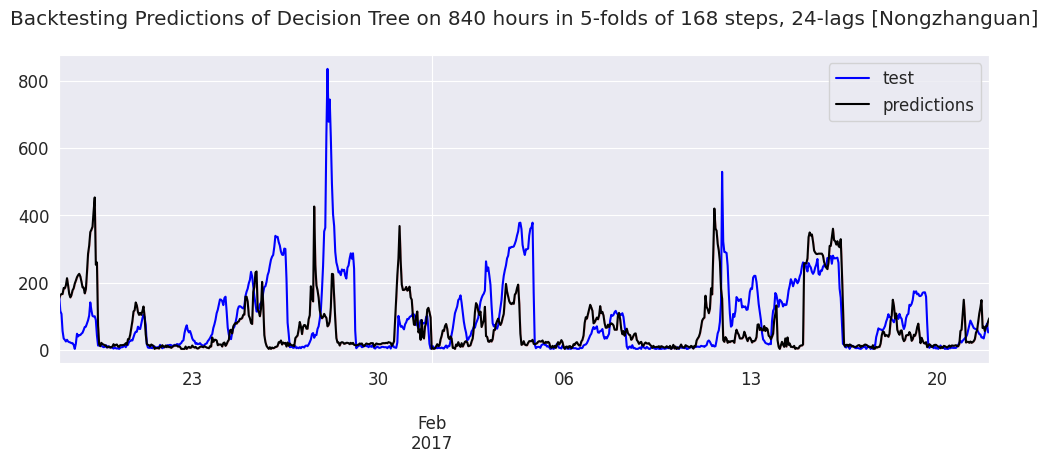

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ytrain_exo_pm25.loc[backtest_predictions.index].plot(ax=ax, label='test', color='blue')
backtest_predictions['pred'].plot(ax=ax, label='predictions', color='black')
ax.fill_between(
    backtest_predictions.index,
    backtest_predictions['lower_bound'],
    backtest_predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.set_title('Backtesting Predictions of Decision Tree on 840 hours in 5-folds of 168 steps, 24-lags [Nongzhanguan]\n')
ax.legend()

In [ ]:
dt_backtest = evaluate_model_performance(
    ytrain_exo_pm25.loc[backtest_predictions.index], 
    backtest_predictions.pred, 
    label='dt_backtest')

dt_backtest

,dt_backtest
MAE,72.841
MSE,13936.540
RMSE,118.053
R-Squared,-0.211
MAPE,1.648


#### Random Forest Regressor (with Backtesting)

In [ ]:
eval_metrics = ['mean_absolute_error', 'mean_squared_error', 
                'mean_absolute_percentage_error']

rf_backtest_forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(
                    n_estimators=150, criterion='squared_error', 
                    bootstrap=True, random_state=60),
        lags      = LAGS
      )

metrics, backtest_predictions = backtesting_forecaster(
        forecaster         = rf_backtest_forecaster,
        y                  = ytrain_exo_pm25,
        initial_train_size = len(ytrain_exo_pm25) - N_BACKTESTING,
        exog               = Xtrain_exo_pm25,
        # interval           = [1, 99],
        fixed_train_size   = False,
        steps              = STEPS,
        metric             = eval_metrics,
        refit              = True,
        verbose            = True
    )

metrics.insert(2, np.sqrt(metrics[1]))
print(f'{"-" * 120}\nBacktest Errors (MAE, MSE, RMSE, MAPE): {metrics}\n{"-" * 120}\n')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168

Data partition in fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Data partition in fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Data partition in fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Data partition in fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Data partition in fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation:

In [ ]:
backtest_predictions.head()

,pred
2017-01-18 00:00:00,180.771111
2017-01-18 01:00:00,186.282963
2017-01-18 02:00:00,190.571852
2017-01-18 03:00:00,204.840741
2017-01-18 04:00:00,196.549524


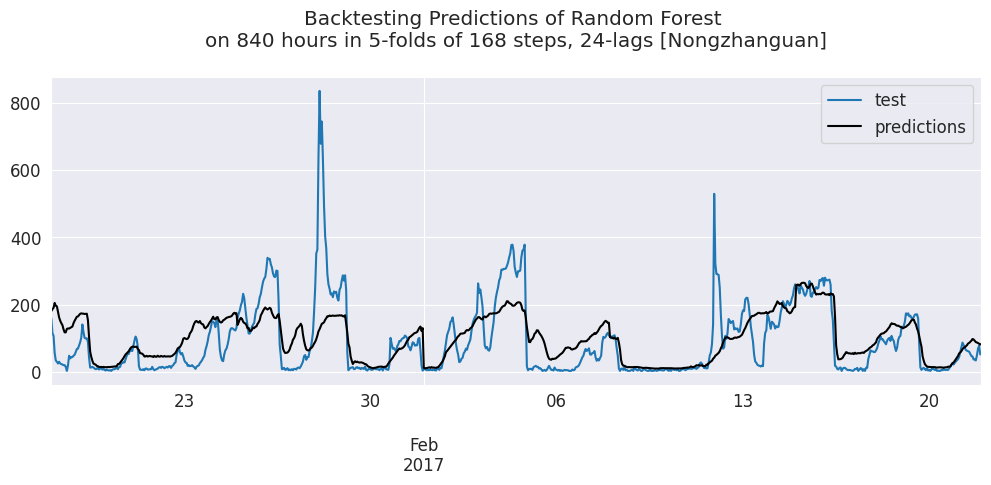

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ytrain_exo_pm25.loc[backtest_predictions.index].plot(ax=ax, label='test')
backtest_predictions['pred'].plot(ax=ax, label='predictions', color='black')
# ax.fill_between(
#     backtest_predictions.index,
#     backtest_predictions['lower_bound'],
#     backtest_predictions['upper_bound'],
#     color = 'red',
#     alpha = 0.2
# )
ax.set_title('Backtesting Predictions of Random Forest \non 840 hours in 5-folds of 168 steps, 24-lags [Nongzhanguan]\n')
ax.legend()

In [ ]:
rf_backtest = evaluate_model_performance(
    ytrain_exo_pm25.loc[backtest_predictions.index], 
    backtest_predictions.pred, 
    label='rf_backtest')

rf_backtest

,rf_backtest
MAE,50.723
MSE,6532.037
RMSE,80.821
R-Squared,0.432
MAPE,2.280


#### Support Vector Machine (Regressor) (with Backtesting)

In [ ]:
eval_metrics = ['mean_absolute_error', 'mean_squared_error', 
                'mean_absolute_percentage_error']

svm_backtest_forecaster = ForecasterAutoreg(
        regressor = LinearSVR(
                    epsilon=0.0, tol=0.0001, 
                    C=1.0, fit_intercept=True, 
                    random_state=60),
        lags      = LAGS
      )

metrics, backtest_predictions = backtesting_forecaster(
        forecaster         = svm_backtest_forecaster,
        y                  = ytrain_exo_pm25,
        initial_train_size = len(ytrain_exo_pm25) - N_BACKTESTING,
        exog               = Xtrain_exo_pm25,
        # interval           = [1, 99],
        fixed_train_size   = False,
        steps              = STEPS,
        metric             = eval_metrics,
        refit              = True,
        verbose            = True
    )

metrics.insert(2, np.sqrt(metrics[1]))
print(f'{"-" * 120}\nBacktest Errors (MAE, MSE, RMSE, MAPE): {metrics}\n{"-" * 120}\n')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168

Data partition in fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Data partition in fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Data partition in fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Data partition in fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Data partition in fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation:

In [ ]:
backtest_predictions.head()

,pred
2017-01-18 00:00:00,184.937751
2017-01-18 01:00:00,199.316592
2017-01-18 02:00:00,211.191502
2017-01-18 03:00:00,225.879492
2017-01-18 04:00:00,239.179466


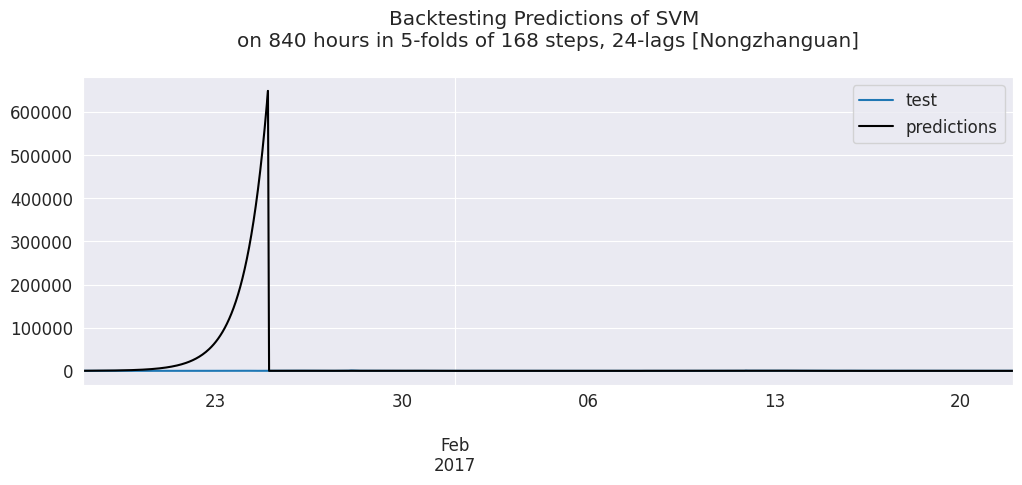

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ytrain_exo_pm25.loc[backtest_predictions.index].plot(ax=ax, label='test')
backtest_predictions['pred'].plot(ax=ax, label='predictions', color='black')
# ax.fill_between(
#     backtest_predictions.index,
#     backtest_predictions['lower_bound'],
#     backtest_predictions['upper_bound'],
#     color = 'red',
#     alpha = 0.2
# )
ax.set_title('Backtesting Predictions of SVM \non 840 hours in 5-folds of 168 steps, 24-lags [Nongzhanguan]\n')
ax.legend()

In [ ]:
svm_backtest = evaluate_model_performance(
    ytrain_exo_pm25.loc[backtest_predictions.index], 
    backtest_predictions.pred, 
    label='svm_backtest')

svm_backtest

,svm_backtest
MAE,1.650692e+04
MSE,5.459481e+09
RMSE,7.388830e+04
R-Squared,-4.744772e+05
MAPE,3.662610e+02


#### Combined Backtesting Performance Results

In [ ]:
backtest_results_exo_sel_24lags = pd.concat([dt_backtest, rf_backtest, svm_backtest], axis='columns')
backtest_results_exo_sel_24lags

,dt_backtest,rf_backtest,svm_backtest
MAE,72.841,50.723,1.650692e+04
MSE,13936.540,6532.037,5.459481e+09
RMSE,118.053,80.821,7.388830e+04
R-Squared,-0.211,0.432,-4.744772e+05
MAPE,1.648,2.280,3.662610e+02


<Axes: title={'center': 'Results of Backtesting with All Algorithms (MAE & RMSE) [Nongzhanguan]\n'}>

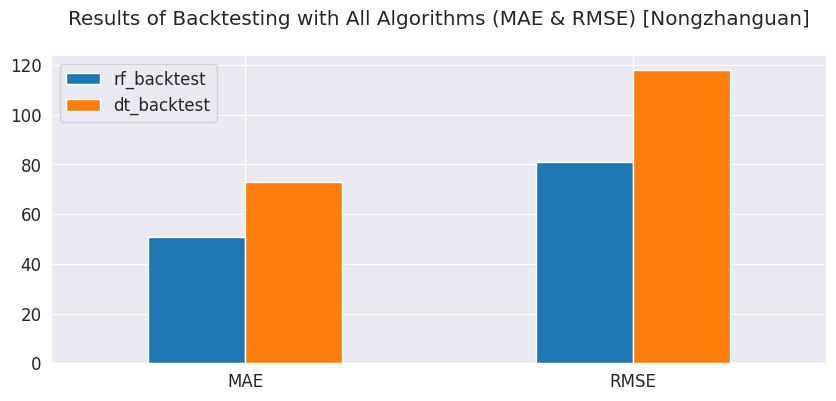

In [ ]:
backtest_results_exo_sel_24lags.T[['MAE', 'RMSE']].sort_values(by='MAE').T.drop(columns=['svm_backtest']).plot.bar(
    title='Results of Backtesting with All Algorithms (MAE & RMSE) [Nongzhanguan]\n', rot=0,
    figsize=(10,4)
)

<Axes: title={'center': 'Mean Absolute Percentage Error (MAPE) of Backtesting with All Algorithms [Nongzhanguan]\n'}>

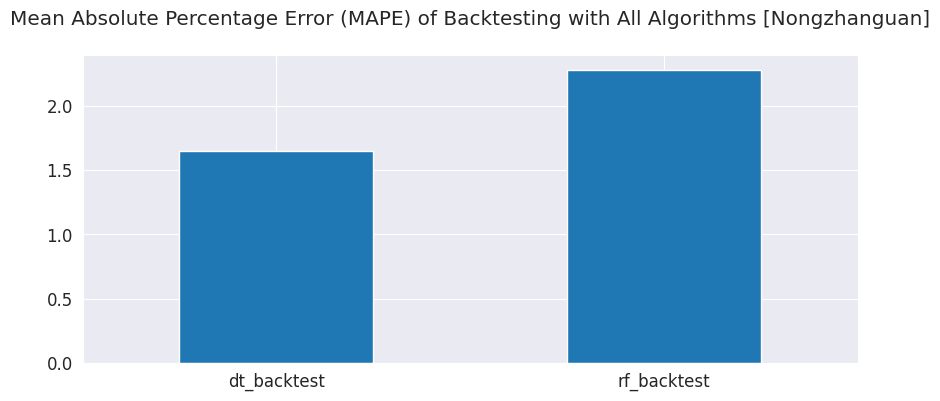

In [ ]:
backtest_results_exo_sel_24lags.T['MAPE'].sort_values().T.drop('svm_backtest').plot.bar(
    title='Mean Absolute Percentage Error (MAPE) of Backtesting with All Algorithms [Nongzhanguan]\n', rot=0,
    figsize=(10,4)
)

In [ ]:
backtest_results_exo_sel_24lags.iloc[3].sort_values()

svm_backtest   -474477.242
dt_backtest         -0.211
rf_backtest          0.432
Name: R-Squared, dtype: float64

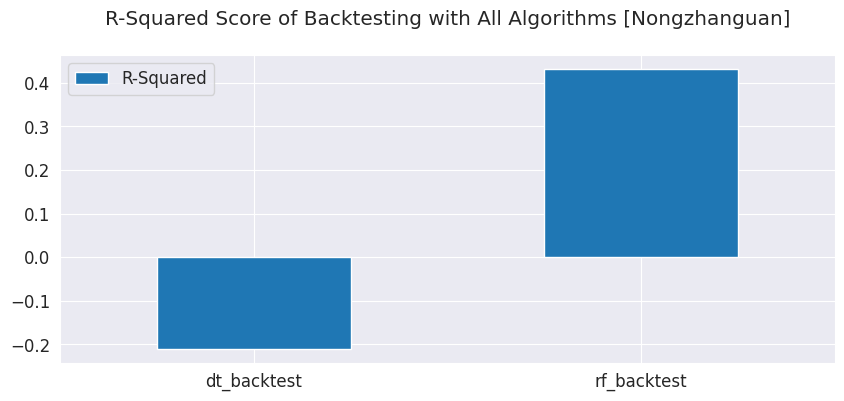

In [ ]:
backtest_results_exo_sel_24lags.iloc[3,:].sort_values()[1:].plot.bar(
    title='R-Squared Score of Backtesting with All Algorithms [Nongzhanguan]\n', rot=0,
    figsize=(10,4)
)
plt.legend()

In [ ]:
# Saving a copy of 24lags backtest results
backtest_results_exo_sel_24lags.to_csv(f'{RESULTS_PATH}/backtest_results_exo_sel_24lags_5folds.csv')

## 2. Grid Search Parameter Tunning

### Seven Days (1 week = 168 hours) Forecast (trained with Exogenous Meterological Predictor Variables included) + All-Features
- Trained with exogenous meterology data
- 24 hours lag (use past 24 hrs data)
- One week (168 hrs) forecast
- Feature Selection (Selection based on Pearson correlation with PM2.5)
- Grid Search Parameter Tunning

In [13]:
STEPS = 24 * 7

#### Preparing data and Feature Selection

**Selected Features are {'WSPM', 'wd', 'TEMP'}**

In [14]:
pm25_exog_data = pd.concat([features_X[['WSPM', 'wd', 'TEMP']], y_pm25], axis='columns')
pm25_exog_data.head(3)

,WSPM,wd,TEMP,PM2.5
datetime,,,,
2013-03-01 00:00:00,5.7,337.5,-0.5,5.0
2013-03-01 01:00:00,3.9,315.0,-0.7,8.0
2013-03-01 02:00:00,5.3,337.5,-1.2,3.0


#### Data Segmentation

In [15]:
# last one month for testing (24 * 31 hours )
Xtrain_exo_pm25, ytrain_exo_pm25, Xtest_exo_pm25, ytest_exo_pm25 = split_train_test_series_multivariate_series(
    df=pm25_exog_data, test_size=STEPS)

print(f'Train set Dates:\t {ytrain_exo_pm25.index.min()}  --- {ytrain_exo_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_exo_pm25.index.min()}  --- {ytest_exo_pm25.index.max()}')

Train set Dates:	 2013-03-01 00:00:00  --- 2017-02-21 23:00:00
Test set Dates:		 2017-02-22 00:00:00  --- 2017-02-28 23:00:00


In [16]:
print(f'Xtrain shape: {Xtrain_exo_pm25.shape}')
print(f'Xtest shape: {Xtest_exo_pm25.shape}')

Xtrain shape: (34896, 3)
Xtest shape: (168, 3)


In [17]:
# Lags used as predictors
LAGS_GRID = [24, 36]

# DTree Regressor's hyperparameters
param_grid_dt = {
    "splitter":["best","random"],
    "max_depth" : [5, 10, 20],
    "max_leaf_nodes":[None, 10, 20] 
    }


# Rabdom Forest Regressor's hyperparameters
param_grid_rf = {
    "n_estimators": [100, 150],
    "max_depth": [20, 40]
    }


# SVM Regressor's hyperparameters
param_grid_svr = {
    'C': [1.0, 5.0, 10.0],
    'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'epsilon': [0.0, 0.01, 0.1,]
    }


#### Decision Tree on PM2.5 (with Hyperparameter Tunning)

In [ ]:
dt_grid_forecaster = ForecasterAutoreg(
        regressor = DecisionTreeRegressor(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )


dt_results_grid = grid_search_forecaster(
        forecaster         = dt_grid_forecaster,
        y                  = ytrain_exo_pm25,
        param_grid         = param_grid_dt,
        lags_grid          = LAGS_GRID,
        steps              = STEPS,
        refit              = True,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(ytrain_exo_pm25)*0.5),
        exog               = Xtrain_exo_pm25,
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
      )


Number of models compared: 54.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [27:27<00:00, 549.25s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 20, 'max_leaf_nodes': None, 'splitter': 'best'}
  Backtesting metric: 8439.957735268828



In [ ]:
# Grid Search results for Decision Tree
# ======================================
dt_results_grid

,lags,params,mean_squared_error,max_depth,max_leaf_nodes,splitter
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'max_leaf_nodes': None, 'spl...",8439.957735,20,NaN,best
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'max_leaf_nodes': None, 'spl...",9138.902986,20,NaN,random
48,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'max_leaf_nodes': None, 'spl...",9176.106820,20,NaN,best
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_leaf_nodes': None, 'spl...",9314.358731,10,NaN,best
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'max_leaf_nodes': None, 'spl...",9415.206224,20,NaN,best
42,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_leaf_nodes': None, 'spl...",9664.912963,10,NaN,best
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_leaf_nodes': None, 'spl...",10158.830048,10,NaN,best
49,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'max_leaf_nodes': None, 'spl...",10347.711196,20,NaN,random
43,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_leaf_nodes': None, 'spl...",10575.264756,10,NaN,random
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_leaf_nodes': None, 'spl...",11333.050364,10,NaN,random


In [ ]:
best_params = {'max_depth': 20, 'max_leaf_nodes': None, 'splitter': 'best'}
best_lag = 24

# Training
dt_grid_forecaster_final = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(
        **best_params,
        random_state=60
        ),
    lags = best_lag)

dt_grid_forecaster_final.fit(y=ytrain_exo_pm25, exog=Xtrain_exo_pm25)
dt_grid_forecaster_final

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=20, random_state=60) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['WSPM', 'wd', 'TEMP'] 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-21 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 60, 'splitter': 'best'} 
Creation date: 2023-05-15 22:09:38 
Last fit date: 2023-05-15 22:09:39 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Forecaster id: None 

In [ ]:
# Predictions
preds_pm25_dt_exo_sel_grid = dt_grid_forecaster_final.predict(steps=STEPS, exog=Xtest_exo_pm25)
preds_pm25_dt_exo_sel_grid.head()

2017-02-22 00:00:00    57.555556
2017-02-22 01:00:00    59.870968
2017-02-22 02:00:00    57.250000
2017-02-22 03:00:00    59.870968
2017-02-22 04:00:00    57.250000
Freq: H, Name: pred, dtype: float64

Text(0.5, 1.0, '7-Days Decision Tree Grid_Search_Params Forecast of PM2.5 + Selected Exogenous \nMeteorological Predictor Variables using 24-lags [Nongzhanguan]\n')

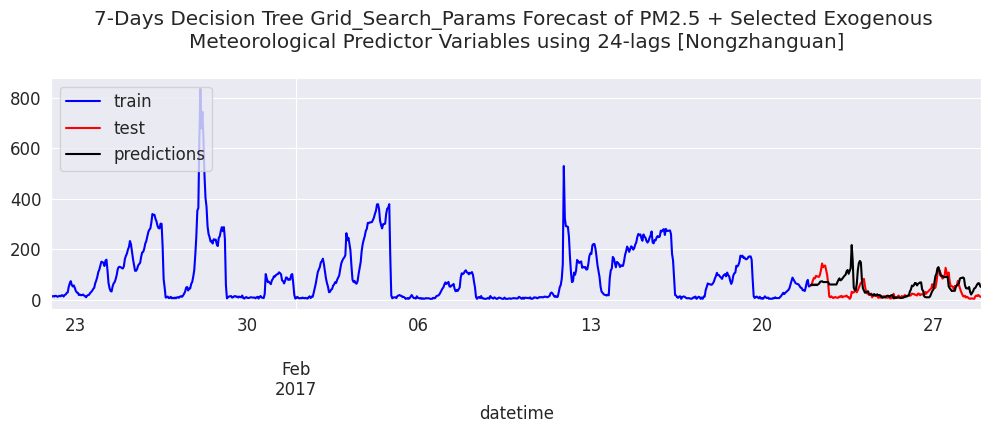

In [ ]:
plt.figure(figsize=(12,3))
ytrain_exo_pm25[-24*31:].plot(color='blue', label='train')
ytest_exo_pm25.plot(color='red', label='test')
preds_pm25_dt_exo_sel_grid.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('7-Days Decision Tree Grid_Search_Params Forecast of PM2.5 + Selected Exogenous \nMeteorological Predictor Variables using 24-lags [Nongzhanguan]\n')

In [ ]:
# Evaluations
results_pm25_dt_notune_exo_sel_grid = evaluate_model_performance(
    y_true=ytest_exo_pm25, 
    predictions=preds_pm25_dt_exo_sel_grid, 
    label='dt_pm25_grid_tune_exo_best_params')

results_pm25_dt_notune_exo_sel_grid

,dt_pm25_grid_tune_exo_best_params
MAE,31.226
MSE,1885.858
RMSE,43.426
R-Squared,-0.534
MAPE,2.211


#### Random Forest (best Hyperparam Grid Search)

In [ ]:
rf_grid_forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )


rf_results_grid = grid_search_forecaster(
        forecaster         = rf_grid_forecaster,
        y                  = ytrain_exo_pm25,
        param_grid         = param_grid_rf, 
        lags_grid          = LAGS_GRID,
        steps              = STEPS,
        refit              = True,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(ytrain_exo_pm25) * 0.5),
        exog               = Xtrain_exo_pm25,
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
      )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
rf_rand_forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )



rf_results_rand = random_search_forecaster(
        forecaster          = rf_rand_forecaster,
        y                   = ytrain_exo_pm25,
        param_distributions = param_grid_rf, 
        lags_grid           = LAGS_GRID,
        steps               = STEPS,
        refit               = True,
        metric              = 'mean_squared_error',
        initial_train_size  = int(len(ytrain_exo_pm25) - (STEPS * 5)),
        exog                = Xtrain_exo_pm25,
        fixed_train_size    = False,
        return_best         = True,
        n_iter              = 5,
        verbose             = True
      )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation: 2017-0

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 34056
Number of observations used for backtesting: 840
    Number of folds: 5
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2013-03-01 00:00:00 -- 2017-01-17 23:00:00  (n=34056)
    Validation: 2017-01-18 00:00:00 -- 2017-01-24 23:00:00  (n=168)
Fold: 1
    Training:   2013-03-01 00:00:00 -- 2017-01-24 23:00:00  (n=34224)
    Validation: 2017-01-25 00:00:00 -- 2017-01-31 23:00:00  (n=168)
Fold: 2
    Training:   2013-03-01 00:00:00 -- 2017-01-31 23:00:00  (n=34392)
    Validation: 2017-02-01 00:00:00 -- 2017-02-07 23:00:00  (n=168)
Fold: 3
    Training:   2013-03-01 00:00:00 -- 2017-02-07 23:00:00  (n=34560)
    Validation: 2017-02-08 00:00:00 -- 2017-02-14 23:00:00  (n=168)
Fold: 4
    Training:   2013-03-01 00:00:00 -- 2017-02-14 23:00:00  (n=34728)
    Validation: 2017-0

In [ ]:
# Grid Search results for Random Forest
# ======================================
rf_results_grid

#### Support Vector Machine Regressor (best Hyperparam Grid Search)

In [ ]:
svm_grid_forecaster = ForecasterAutoreg(
        regressor = LinearSVR(random_state=60),
        lags      = 24 # This value is replaced in the grid search
      )


svr_results_grid = grid_search_forecaster(
        forecaster         = svm_grid_forecaster,
        y                  = ytrain_exo_pm25,
        param_grid         = param_grid_svr,
        lags_grid          = LAGS_GRID,
        steps              = STEPS,
        refit              = True,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(ytrain_exo_pm25)*0.5),
        exog               = Xtrain_exo_pm25,
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
      )

Number of models compared: 36.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

params grid:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
# Grid Search results for Support Vector Machine (Regressor)
# ==========================================================
svr_results_grid

---

---
# ACCESSING THE POTENTIALS OF METEROLOGICAL VARIABLES IN PREDICTING within-Sample PM2.5 (using Machine Learning Approach)

---

---

## Prediction

### Data Preparation and Segmentation

In [ ]:
TEST_SIZE = int((30 / 100) * len(y_pm25))

print(f'Test Size (30%): {TEST_SIZE}')

Test Size (30%): 10519


In [ ]:
features_X.corrwith(y_pm25).sort_values()

WSPM   -0.301098
wd     -0.240711
TEMP   -0.173362
RAIN   -0.022705
PRES    0.028121
DEWP    0.097226
dtype: float64

In [ ]:
data = pd.concat([features_X, y_pm25], axis='columns')
data.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5
datetime,,,,,,,
2013-03-01 00:00:00,-0.5,1024.5,-21.4,0.0,337.5,5.7,5.0
2013-03-01 01:00:00,-0.7,1025.1,-22.1,0.0,315.0,3.9,8.0
2013-03-01 02:00:00,-1.2,1025.3,-24.6,0.0,337.5,5.3,3.0


In [ ]:
# Train test split
X_train, y_train, X_test, y_test = split_train_test_series_multivariate_series(
    data, test_size=TEST_SIZE)

In [ ]:
print(f'Shape of X: {features_X.shape}')
print(f'Shape of X-train: {X_train.shape}')
print(f'Shape of X-test: {X_test.shape}')

Shape of X: (35064, 6)
Shape of X-train: (24545, 6)
Shape of X-test: (10519, 6)


In [ ]:
X_train.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2013-03-01 00:00:00,-0.5,1024.5,-21.4,0.0,337.5,5.7
2013-03-01 01:00:00,-0.7,1025.1,-22.1,0.0,315.0,3.9
2013-03-01 02:00:00,-1.2,1025.3,-24.6,0.0,337.5,5.3


In [ ]:
y_train.head(3)

datetime
2013-03-01 00:00:00    5.0
2013-03-01 01:00:00    8.0
2013-03-01 02:00:00    3.0
Freq: H, Name: PM2.5, dtype: float64

In [ ]:
X_test.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
datetime,,,,,,
2015-12-18 17:00:00,3.5,1030.5,-10.6,0.0,112.5,2.1
2015-12-18 18:00:00,1.5,1031.3,-9.5,0.0,247.5,0.3
2015-12-18 19:00:00,-0.8,1032.0,-8.5,0.0,135.0,0.6


In [ ]:
y_test.head(3)

datetime
2015-12-18 17:00:00    14.0
2015-12-18 18:00:00    23.0
2015-12-18 19:00:00    31.0
Freq: H, Name: PM2.5, dtype: float64

### Decision Tree

In [ ]:
# initializing model
dt_pm25 = DecisionTreeRegressor(criterion='squared_error', min_samples_split=2, 
                                random_state=60)

# training the model
dt_pm25.fit(X_train, y_train)

# making prediction
dt_pred_pm25 = dt_pm25.predict(X_test)

In [ ]:
# Evaluations
dt_results_pm25 = evaluate_model_performance(
    y_true=y_test, predictions=dt_pred_pm25, label='dt_pm25')

dt_results_pm25

,dt_pm25
MAE,63.906
MSE,9450.183
RMSE,97.212
R-Squared,-0.121
MAPE,1.695


### SVM Regressor

In [ ]:
# initializing model
svr_pm25 = LinearSVR(epsilon=0.0, tol=0.0001, C=1.0, fit_intercept=True, random_state=60)

# training the model
svr_pm25.fit(X_train, y_train)

# making prediction
svr_pred_pm25 = svr_pm25.predict(X_test)

In [ ]:
# Evaluations
svr_results_pm25 = evaluate_model_performance(
    y_true=y_test, predictions=svr_pred_pm25, label='svr_pm25')

svr_results_pm25

,svr_pm25
MAE,96.365
MSE,11871.981
RMSE,108.959
R-Squared,-0.408
MAPE,5.238


### RF Regressor

In [ ]:
# initializing model
rf_pm25 = RandomForestRegressor(
    n_estimators=150, criterion='squared_error', 
    bootstrap=True, random_state=60)

# training the model
rf_pm25.fit(X_train, y_train)

# making prediction
rf_pred_pm25 = rf_pm25.predict(X_test)

In [ ]:
# Evaluations
rf_results_pm25 = evaluate_model_performance(
    y_true=y_test, predictions=rf_pred_pm25, label='rf_pm25')

rf_results_pm25

,rf_pm25
MAE,48.534
MSE,5170.553
RMSE,71.907
R-Squared,0.387
MAPE,1.431


### PM2.5 Models Performance Comparisons

In [ ]:
results_pm25 = pd.concat([dt_results_pm25, rf_results_pm25, svr_results_pm25], axis='columns')

results_pm25

,dt_pm25,rf_pm25,svr_pm25
MAE,63.906,48.534,96.365
MSE,9450.183,5170.553,11871.981
RMSE,97.212,71.907,108.959
R-Squared,-0.121,0.387,-0.408
MAPE,1.695,1.431,5.238


<Axes: title={'center': 'Machine Learning Approach for Meterological Variables Predictions of PM2.5 [Nongzhanguan]\n'}>

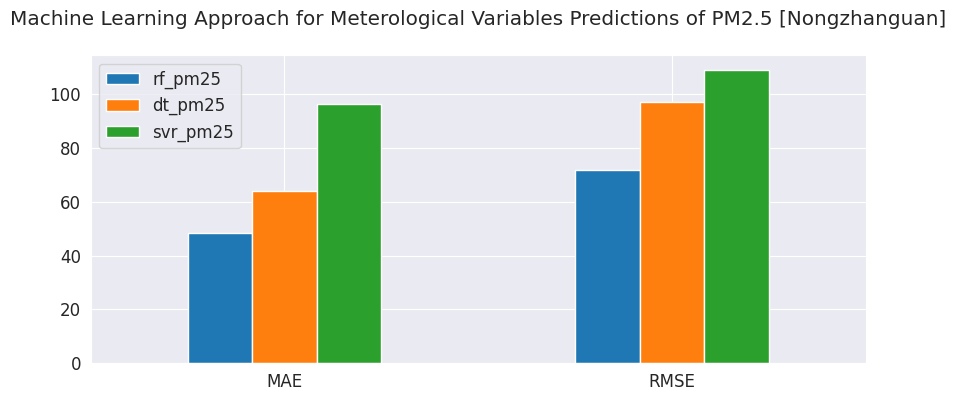

In [ ]:
results_pm25.iloc[[0, 2],:].T.sort_values(by='MAE').T.plot.bar(
    title='Machine Learning Approach for Meterological Variables Predictions of PM2.5 [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'Mean Absolute Error(MAE) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n'}>

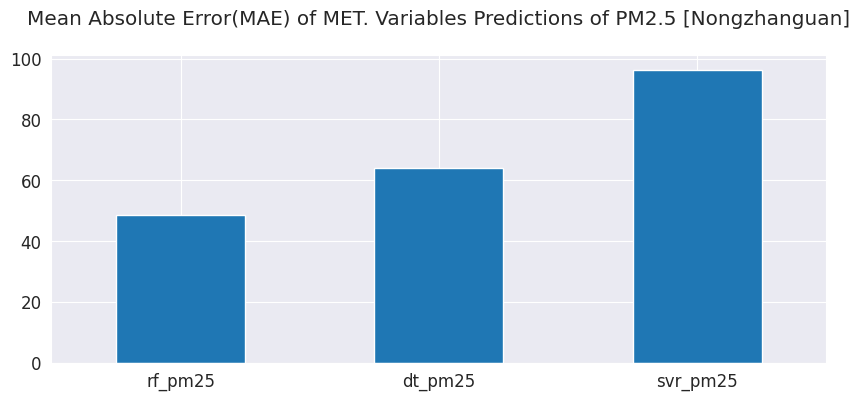

In [ ]:
results_pm25.iloc[0,:].T.sort_values().T.plot.bar(
    title='Mean Absolute Error(MAE) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'Mean Squared Error(MSE) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n'}>

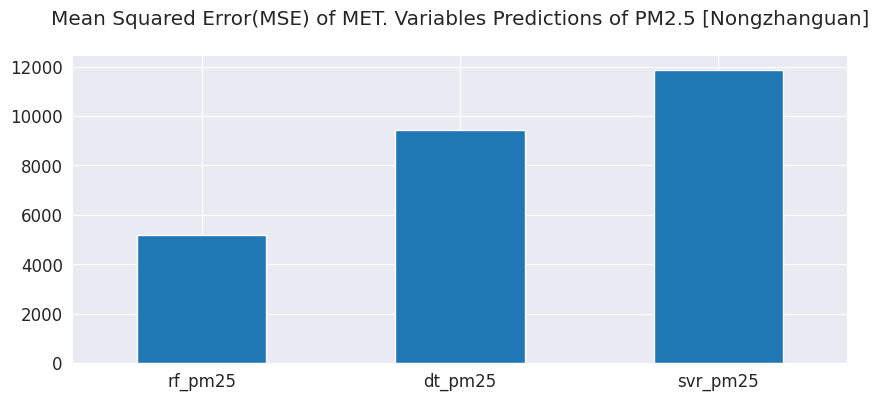

In [ ]:
results_pm25.iloc[1,:].T.sort_values().T.plot.bar(
    title='Mean Squared Error(MSE) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'Root Mean Squared Error(RMSE) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n'}>

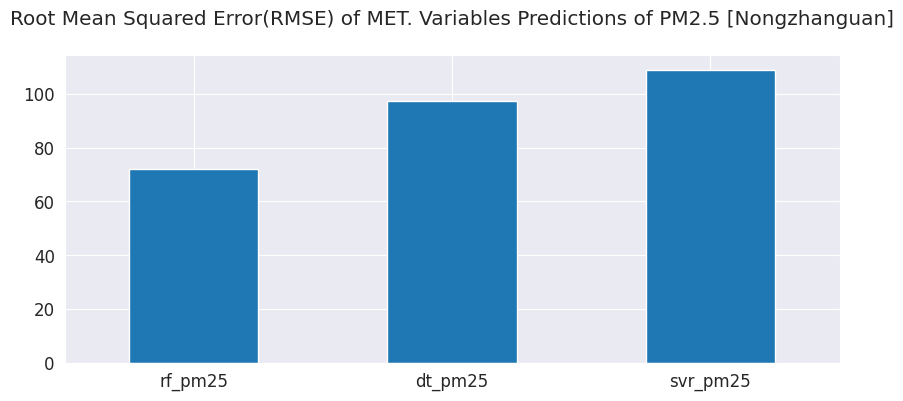

In [ ]:
results_pm25.iloc[2,:].T.sort_values().T.plot.bar(
    title='Root Mean Squared Error(RMSE) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'MAPE (Mean Absolute Percentage Error) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n'}>

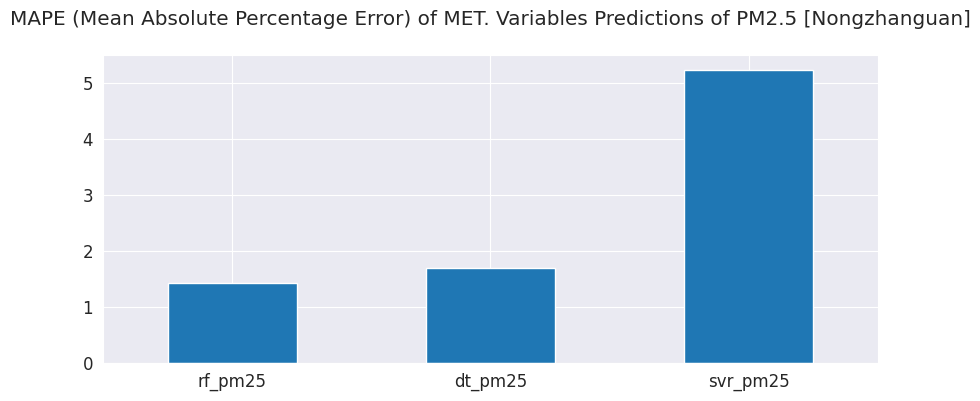

In [ ]:
results_pm25.iloc[4].T.sort_values().T.plot.bar(
    title='MAPE (Mean Absolute Percentage Error) of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n', 
    figsize=(10,4), rot=0)

<Axes: title={'center': 'R-Squred Score of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n'}>

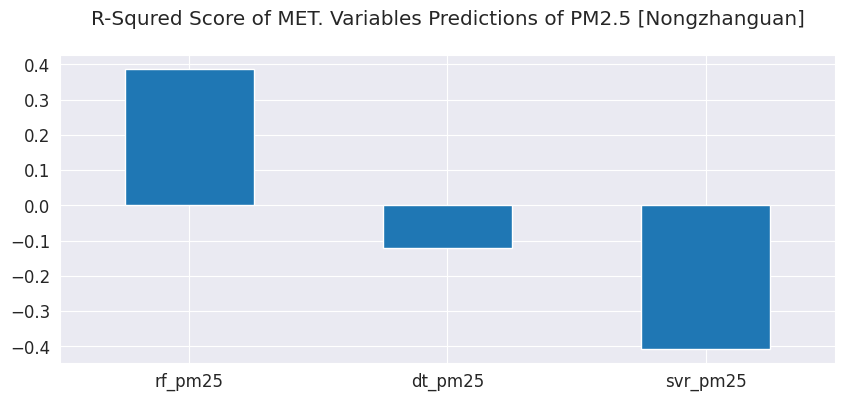

In [ ]:
results_pm25.iloc[3].T.sort_values(ascending=False).T.plot.bar(
    title='R-Squred Score of MET. Variables Predictions of PM2.5 [Nongzhanguan]\n',
    figsize=(10,4), rot=0)

In [ ]:
# Saving a copy of results
results_pm25.to_csv(f'{RESULTS_PATH}/results_Nongzhanguan_ML_Approach_meterology_to_PM25.csv')